In [2]:
import torchvision
print(torchvision.__version__)
%matplotlib inline

0.21.0+cu124


In [3]:
import os, sys
from google.colab import drive
drive.mount('/content/drive') # only run when creating notebook for the first time
sys.path.append('/content/drive/MyDrive/final_project')

Mounted at /content/drive


In [4]:
# TODO: Fill in the Google Drive path where you uploaded assignment1
# Example: If you create a Fall2023 folder and put all the files under A1 folder, then 'Fall2023/A1'
GOOGLE_DRIVE_PATH_POST_MYDRIVE = 'final_project'
GOOGLE_DRIVE_PATH = os.path.join('/content', 'drive', 'MyDrive', GOOGLE_DRIVE_PATH_POST_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['project_env.yaml', 'train_model.py', 'collect_code.sh', 'Test_baseTrainer.ipynb', 'tsne_results.pkl', 'Test_Trainer_callback.ipynb', 'callbacks', 'logs', 'models', 'tutorials', 'configs', 'data_loader', 'data', 'trainers', 'tests', 'losses', 'utils', 'Test_Trainer_callback_RNA_seq.ipynb', 'Test_Trainer_callback_RNA_seq_CNN.ipynb']


In [5]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [6]:
from utils import Config
from data_loader import MultiOmicsDataset, create_dataloaders

In [7]:
# # Reload all modules every time before executing code
%load_ext autoreload
%autoreload 2

### 7. Run pytest

In [8]:
# %%bash
# pytest -v

In [9]:
import json
from pathlib import Path
from sklearn.metrics import classification_report, accuracy_score
import torch

In [10]:
from utils import Config
from data_loader import MultiOmicsDataset, create_dataloaders
from models import MultiOmicsClassifier, SingleOmicsClassifierCNN
from trainers import BaseTrainer
from losses import MultiOmicsLoss, RNASeqLoss

In [11]:
from trainers import CallbackTrainer
from callbacks import LossRecorderCallback, TSNERecorderCallback, TSNERecorderCallbackSingleOmic
from callbacks import AccuracyRecorderCallback
from callbacks import AttentionLoggerCallback
from utils import plot_tsne, plot_loss

def extract_latent(outputs):
    """Example: Extract latent representation from your specific model outputs"""
    return outputs['latent_rep']  # Replace with your actual latent key
    # Or if using concatenated features:
    # return torch.cat([outputs['mirna_latent'], outputs['rna_latent']], dim=1)

In [12]:
def get_training_parameters(trainer, include_model_info=False, include_optimizer_state=False):
    """Extracts all relevant training parameters in a structured dictionary.

    Args:
        trainer: BaseTrainer instance
        include_model_info: Whether to include model architecture details
        include_optimizer_state: Whether to include optimizer state details

    Returns:
        Dictionary containing all training parameters
    """
    params = {
        "training": {
            "device": str(trainer.device),
        },
        "loss": {
            "type": type(trainer.loss_fn).__name__,
            "beta": getattr(trainer.loss_fn, 'target_beta', None),
            "use_focal": getattr(trainer.loss_fn, 'use_focal', None),
            "focal_gamma": getattr(trainer.loss_fn, 'focal_gamma', None),
            "label_smoothing": getattr(trainer.loss_fn, 'label_smoothing', None),
            "kl_epsilon": getattr(trainer.loss_fn, 'kl_epsilon', None)
        },
        "optimizer": {
            "type": type(trainer.optimizer).__name__,
            "lr": trainer.optimizer.param_groups[0]['lr'],
            "betas": trainer.optimizer.param_groups[0].get('betas', None),
            "eps": trainer.optimizer.param_groups[0].get('eps', None),
            "weight_decay": trainer.optimizer.param_groups[0].get('weight_decay', None)
        }
    }

    if include_model_info:
        params["model"] = {
            "type": type(trainer.model).__name__,
            "total_parameters": sum(p.numel() for p in trainer.model.parameters()),
            "trainable_parameters": sum(p.numel() for p in trainer.model.parameters()
                                      if p.requires_grad),
            "architecture": str(trainer.model)  # This shows the model structure
        }

    if include_optimizer_state:
        params["optimizer"]["state"] = {
            "momentum_buffer": any('momentum_buffer' in p for p in trainer.optimizer.state.values())
        }


    return params

# RNA-seq Only Models

In [13]:
config = Config.from_yaml("/content/drive/MyDrive/final_project/configs/data_rna_config.yaml")

dataset = MultiOmicsDataset(config)
dataloaders = create_dataloaders(dataset, config)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [14]:
#Apoorva
rna_exp_dim = 13054
latent_dim = 16
num_classes = 5

# Instantiate model
singleomics_model = SingleOmicsClassifierCNN(
    rna_exp_dim=rna_exp_dim,
    latent_dim=latent_dim,
    num_classes=num_classes
)

In [15]:
trainer = BaseTrainer(
    model=singleomics_model,
    optimizer=torch.optim.Adam(singleomics_model.parameters(), lr=1e-3),
    loss_fn=RNASeqLoss(),
    device=device
)

trainer.fit(train_loader=dataloaders['train'], val_loader=dataloaders['val'], epochs=10)

Validation: 100%|██████████| 2/2 [00:00<00:00,  6.29it/s]



📆 Epoch 1/10
🧮 Train Loss: 1.4904
🧪 Val Loss:   1.5228


Training:  80%|████████  | 4/5 [00:00<00:00,  5.01it/s, loss=1.35]

step    10 | loss: 1.3429 | ce: 1.3429 | kl: 0.0000 | beta: 0.0076


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.09it/s]



📆 Epoch 2/10
🧮 Train Loss: 1.4053
🧪 Val Loss:   1.5172


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.23it/s]



📆 Epoch 3/10
🧮 Train Loss: 1.3139
🧪 Val Loss:   1.5215


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.80it/s]



📆 Epoch 4/10
🧮 Train Loss: 1.3017
🧪 Val Loss:   1.7739


Training:  60%|██████    | 3/5 [00:00<00:00,  4.49it/s, loss=1.4]

step    30 | loss: 1.3502 | ce: 1.3502 | kl: 0.0000 | beta: 0.0077


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.32it/s]



📆 Epoch 5/10
🧮 Train Loss: 1.3079
🧪 Val Loss:   1.5230


Training: 100%|██████████| 5/5 [00:01<00:00,  4.91it/s, loss=1.43]


step    40 | loss: 1.4311 | ce: 1.4311 | kl: 0.0000 | beta: 0.0077


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.46it/s]



📆 Epoch 6/10
🧮 Train Loss: 1.2910
🧪 Val Loss:   1.5134


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.54it/s]



📆 Epoch 7/10
🧮 Train Loss: 1.1179
🧪 Val Loss:   2.0835


Training:  40%|████      | 2/5 [00:00<00:00,  3.77it/s, loss=1.32]

step    50 | loss: 1.0306 | ce: 1.0306 | kl: 0.0000 | beta: 0.0078


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.04it/s]



📆 Epoch 8/10
🧮 Train Loss: 1.2463
🧪 Val Loss:   2.3768


Training: 100%|██████████| 5/5 [00:01<00:00,  4.93it/s, loss=1.25]


step    60 | loss: 1.1400 | ce: 1.1400 | kl: 0.0000 | beta: 0.0078


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.18it/s]



📆 Epoch 9/10
🧮 Train Loss: 1.0785
🧪 Val Loss:   1.2925


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.57it/s]


📆 Epoch 10/10
🧮 Train Loss: 0.9261
🧪 Val Loss:   2.7840


In [16]:
preds, targets = trainer.predict(dataloaders["test"])

# Compute accuracy
acc = accuracy_score(targets.numpy(), preds.numpy())
print(f"✅ Test Accuracy: {acc:.4f}")

✅ Test Accuracy: 0.4394


In [17]:
print(classification_report(targets.numpy(), preds.numpy()))

params = get_training_parameters(trainer)
print(json.dumps(params, indent=4))

              precision    recall  f1-score   support

           0       0.44      1.00      0.61        29
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00         9
           4       0.00      0.00      0.00         4

    accuracy                           0.44        66
   macro avg       0.09      0.20      0.12        66
weighted avg       0.19      0.44      0.27        66

{
    "training": {
        "device": "cuda"
    },
    "loss": {
        "type": "RNASeqLoss",
        "beta": 0.1,
        "use_focal": false,
        "focal_gamma": 2.0,
        "label_smoothing": 0.0,
        "kl_epsilon": 1e-08
    },
    "optimizer": {
        "type": "Adam",
        "lr": 0.001,
        "betas": [
            0.9,
            0.999
        ],
        "eps": 1e-08,
        "weight_decay": 0
    }
}


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [18]:
model_no = 0
loss_fn = RNASeqLoss(
    beta=0.25,               # Target KL weight
    # annealing_steps=5000,   # Total steps to anneal over
    # use_focal=True,
    # focal_gamma=1,
    # label_smoothing=0.1,
    # class_weights=None # or torch.tensor([...], device="cuda")
)

rna_exp_dim = 13054
latent_dim = 32
num_classes = 5

# Instantiate model
singleomics_model = SingleOmicsClassifierCNN(
    rna_exp_dim=rna_exp_dim,
    latent_dim=latent_dim,
    num_classes=num_classes
)



loss_callback = LossRecorderCallback(save_path=GOOGLE_DRIVE_PATH + "/logs/rna_seq_cnn/loss_history_{0}.json".format(model_no))
tsne_callback = TSNERecorderCallbackSingleOmic(
    val_loader=dataloaders['val'],  # Your validation DataLoader
    device=device,
    save_path=GOOGLE_DRIVE_PATH + "/logs/rna_seq_cnn/tsne_results_{0}.pkl".format(model_no)  # Matches your plot_tsne() default
)

trainer_cb = CallbackTrainer(
    model=singleomics_model,
    optimizer=torch.optim.AdamW(singleomics_model.parameters(), lr=2e-4, weight_decay=0.01),
    loss_fn=loss_fn,
    device=device,
    callbacks=[loss_callback, tsne_callback]
)

trainer_cb.fit(train_loader=dataloaders['train'], val_loader=dataloaders['val'], epochs=50)


Epoch 1/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  3.33it/s, loss=1.57]


Train Loss: 1.5794


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.29it/s]

Val Loss:   1.6271



Epoch 2/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training:  80%|████████  | 4/5 [00:00<00:00,  4.68it/s, loss=1.5]

step    10 | loss: 1.4786 | ce: 1.4786 | kl: 0.0000 | beta: 0.0190


Training: 100%|██████████| 5/5 [00:01<00:00,  4.55it/s, loss=1.4]


Train Loss: 1.4810


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.40it/s]

Val Loss:   1.5843



Epoch 3/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  4.83it/s, loss=1.43]


Train Loss: 1.4403


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.31it/s]

Val Loss:   1.4558



Epoch 4/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  4.89it/s, loss=1.48]


Train Loss: 1.3963


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.23it/s]

Val Loss:   1.4173



Epoch 5/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training:  60%|██████    | 3/5 [00:00<00:00,  4.54it/s, loss=1.32]

step    30 | loss: 1.2766 | ce: 1.2766 | kl: 0.0000 | beta: 0.0192


Training: 100%|██████████| 5/5 [00:01<00:00,  4.91it/s, loss=1.42]


Train Loss: 1.3503


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.25it/s]

Val Loss:   1.4998



Epoch 6/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  4.21it/s, loss=1.14]


step    40 | loss: 1.1371 | ce: 1.1371 | kl: 0.0000 | beta: 0.0193
Train Loss: 1.2402


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.05it/s]

Val Loss:   1.5429



Epoch 7/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  3.82it/s, loss=0.797]


Train Loss: 1.0513


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.85it/s]

Val Loss:   1.6444



Epoch 8/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training:  40%|████      | 2/5 [00:00<00:00,  3.58it/s, loss=1.06]

step    50 | loss: 0.9644 | ce: 0.9644 | kl: 0.0000 | beta: 0.0194


Training: 100%|██████████| 5/5 [00:01<00:00,  4.57it/s, loss=1.82]


Train Loss: 1.1455


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.69it/s]

Val Loss:   1.0680



Epoch 9/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  4.71it/s, loss=1.47]


step    60 | loss: 0.9160 | ce: 0.9160 | kl: 0.0000 | beta: 0.0195
Train Loss: 1.1124


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.92it/s]

Val Loss:   1.6018



Epoch 10/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  4.88it/s, loss=0.9]


Train Loss: 0.8684


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.14it/s]

Val Loss:   1.3160



Epoch 11/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  4.84it/s, loss=1.02]


Train Loss: 0.8245


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.19it/s]

Val Loss:   1.4803



Epoch 12/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training:  80%|████████  | 4/5 [00:01<00:00,  4.13it/s, loss=0.745]

step    80 | loss: 0.7270 | ce: 0.7270 | kl: 0.0000 | beta: 0.0197


Training: 100%|██████████| 5/5 [00:01<00:00,  3.68it/s, loss=0.639]


Train Loss: 0.7019


Validation: 100%|██████████| 2/2 [00:00<00:00,  3.85it/s]

Val Loss:   1.0625



Epoch 13/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  4.58it/s, loss=0.682]


Train Loss: 0.6302


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.96it/s]

Val Loss:   0.6778



Epoch 14/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  4.75it/s, loss=0.274]


Train Loss: 0.5004


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.24it/s]

Val Loss:   1.5355



Epoch 15/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training:  60%|██████    | 3/5 [00:00<00:00,  4.52it/s, loss=0.454]

step   100 | loss: 0.4926 | ce: 0.4926 | kl: 0.0000 | beta: 0.0199


Training: 100%|██████████| 5/5 [00:01<00:00,  4.89it/s, loss=0.522]


Train Loss: 0.5196


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.01it/s]

Val Loss:   0.6852



Epoch 16/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  4.91it/s, loss=0.827]


step   110 | loss: 0.8267 | ce: 0.8267 | kl: 0.0000 | beta: 0.0199
Train Loss: 0.5394


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.28it/s]

Val Loss:   0.9162



Epoch 17/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  4.59it/s, loss=0.424]


Train Loss: 0.4653


Validation: 100%|██████████| 2/2 [00:00<00:00,  3.86it/s]

Val Loss:   0.8245



Epoch 18/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training:  40%|████      | 2/5 [00:00<00:01,  2.69it/s, loss=0.452]

step   120 | loss: 0.4578 | ce: 0.4578 | kl: 0.0000 | beta: 0.0200


Training: 100%|██████████| 5/5 [00:01<00:00,  3.71it/s, loss=0.307]


Train Loss: 0.3948


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.59it/s]

Val Loss:   0.4708



Epoch 19/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  4.82it/s, loss=0.488]


step   130 | loss: 0.4308 | ce: 0.4308 | kl: 0.0000 | beta: 0.0201
Train Loss: 0.4012


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.00it/s]

Val Loss:   1.0211



Epoch 20/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  4.71it/s, loss=0.348]


Train Loss: 0.3194


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.71it/s]

Val Loss:   0.6048



Epoch 21/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  4.71it/s, loss=0.94]


Train Loss: 0.3866


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.12it/s]

Val Loss:   0.6146



Epoch 22/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training:  80%|████████  | 4/5 [00:00<00:00,  4.86it/s, loss=0.26]

step   150 | loss: 0.4136 | ce: 0.4136 | kl: 0.0000 | beta: 0.0203


Training: 100%|██████████| 5/5 [00:01<00:00,  4.75it/s, loss=0.523]


Train Loss: 0.3335


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.30it/s]

Val Loss:   3.2523



Epoch 23/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  4.19it/s, loss=0.123]


Train Loss: 0.3746


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.14it/s]

Val Loss:   1.2812



Epoch 24/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  3.75it/s, loss=0.0743]


Train Loss: 0.2140


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.40it/s]

Val Loss:   4.4260



Epoch 25/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training:  60%|██████    | 3/5 [00:00<00:00,  4.41it/s, loss=0.213]

step   170 | loss: 0.2084 | ce: 0.2084 | kl: 0.0000 | beta: 0.0205


Training: 100%|██████████| 5/5 [00:01<00:00,  4.76it/s, loss=0.361]


Train Loss: 0.2287


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.99it/s]

Val Loss:   2.4774



Epoch 26/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  4.69it/s, loss=0.228]


step   180 | loss: 0.2284 | ce: 0.2284 | kl: 0.0000 | beta: 0.0206
Train Loss: 0.2452


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.27it/s]

Val Loss:   1.0904



Epoch 27/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  4.82it/s, loss=0.125]


Train Loss: 0.1946


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.16it/s]

Val Loss:   2.9511



Epoch 28/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training:  40%|████      | 2/5 [00:00<00:00,  3.76it/s, loss=0.194]

step   190 | loss: 0.1631 | ce: 0.1631 | kl: 0.0000 | beta: 0.0207


Training: 100%|██████████| 5/5 [00:01<00:00,  4.76it/s, loss=0.855]


Train Loss: 0.3360


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.71it/s]

Val Loss:   2.1761



Epoch 29/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  3.80it/s, loss=0.309]


step   200 | loss: 0.5986 | ce: 0.5986 | kl: 0.0000 | beta: 0.0208
Train Loss: 0.3317


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.14it/s]

Val Loss:   0.7300



Epoch 30/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  4.32it/s, loss=0.564]


Train Loss: 0.3262


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.71it/s]

Val Loss:   2.5006



Epoch 31/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  4.66it/s, loss=0.29]


Train Loss: 0.2391


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.11it/s]

Val Loss:   1.4405



Epoch 32/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training:  80%|████████  | 4/5 [00:00<00:00,  4.76it/s, loss=0.0902]

step   220 | loss: 0.1000 | ce: 0.1000 | kl: 0.0000 | beta: 0.0210


Training: 100%|██████████| 5/5 [00:01<00:00,  4.73it/s, loss=0.333]


Train Loss: 0.1926


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.00it/s]

Val Loss:   1.2320



Epoch 33/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  4.74it/s, loss=0.0401]


Train Loss: 0.1171


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.13it/s]

Val Loss:   0.4443



Epoch 34/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  4.67it/s, loss=0.125]


Train Loss: 0.1224


Validation: 100%|██████████| 2/2 [00:00<00:00,  3.73it/s]

Val Loss:   0.3671



Epoch 35/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training:  60%|██████    | 3/5 [00:00<00:00,  3.54it/s, loss=0.108]

step   240 | loss: 0.1092 | ce: 0.1092 | kl: 0.0000 | beta: 0.0212


Training: 100%|██████████| 5/5 [00:01<00:00,  3.86it/s, loss=0.038]


Train Loss: 0.0870


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.20it/s]

Val Loss:   0.9676



Epoch 36/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  4.78it/s, loss=0.0793]


step   250 | loss: 0.0793 | ce: 0.0793 | kl: 0.0000 | beta: 0.0213
Train Loss: 0.0917


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.99it/s]

Val Loss:   0.8990



Epoch 37/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  4.66it/s, loss=0.236]


Train Loss: 0.1156


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.97it/s]

Val Loss:   0.7685



Epoch 38/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training:  40%|████      | 2/5 [00:00<00:00,  3.58it/s, loss=0.0825]

step   260 | loss: 0.0642 | ce: 0.0642 | kl: 0.0000 | beta: 0.0214


Training: 100%|██████████| 5/5 [00:01<00:00,  4.62it/s, loss=1.03]


Train Loss: 0.3084


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.66it/s]

Val Loss:   1.1223



Epoch 39/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  4.67it/s, loss=0.134]


step   270 | loss: 0.1100 | ce: 0.1100 | kl: 0.0000 | beta: 0.0215
Train Loss: 0.1229


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.26it/s]

Val Loss:   2.0619



Epoch 40/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  3.82it/s, loss=3.34]


Train Loss: 0.8802


Validation: 100%|██████████| 2/2 [00:00<00:00,  3.66it/s]

Val Loss:   1.4080



Epoch 41/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  4.43it/s, loss=1.44]


Train Loss: 0.6823


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.19it/s]

Val Loss:   2.3476



Epoch 42/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training:  80%|████████  | 4/5 [00:00<00:00,  4.74it/s, loss=0.473]

step   290 | loss: 0.3538 | ce: 0.3538 | kl: 0.0000 | beta: 0.0217


Training: 100%|██████████| 5/5 [00:01<00:00,  4.65it/s, loss=0.437]


Train Loss: 0.4293


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.74it/s]

Val Loss:   2.7200



Epoch 43/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  4.60it/s, loss=0.314]


Train Loss: 0.3641


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.06it/s]

Val Loss:   1.6528



Epoch 44/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  4.66it/s, loss=0.91]


Train Loss: 0.3374


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.11it/s]

Val Loss:   1.5603



Epoch 45/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training:  60%|██████    | 3/5 [00:00<00:00,  4.19it/s, loss=0.103]

step   310 | loss: 0.1720 | ce: 0.1720 | kl: 0.0000 | beta: 0.0219


Training: 100%|██████████| 5/5 [00:01<00:00,  4.37it/s, loss=0.129]


Train Loss: 0.1670


Validation: 100%|██████████| 2/2 [00:00<00:00,  3.60it/s]

Val Loss:   0.9825



Epoch 46/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  3.62it/s, loss=0.405]


step   320 | loss: 0.4052 | ce: 0.4052 | kl: 0.0000 | beta: 0.0220
Train Loss: 0.2225


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.20it/s]

Val Loss:   0.8358



Epoch 47/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  4.26it/s, loss=0.431]


Train Loss: 0.1740


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.03it/s]

Val Loss:   0.9559



Epoch 48/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training:  40%|████      | 2/5 [00:00<00:00,  3.61it/s, loss=0.228]

step   330 | loss: 0.0943 | ce: 0.0943 | kl: 0.0000 | beta: 0.0221


Training: 100%|██████████| 5/5 [00:01<00:00,  4.63it/s, loss=1.14]


Train Loss: 0.3562


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.54it/s]

Val Loss:   0.7801



Epoch 49/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  4.69it/s, loss=0.171]


step   340 | loss: 0.1200 | ce: 0.1200 | kl: 0.0000 | beta: 0.0222
Train Loss: 0.1678


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.91it/s]

Val Loss:   0.9995



Epoch 50/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  4.53it/s, loss=0.151]


Train Loss: 0.1795


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.86it/s]

Val Loss:   0.4571


In [19]:
preds, targets = trainer_cb.predict(dataloaders["test"])
acc = accuracy_score(targets.numpy(), preds.numpy())
print(f"✅ Test Accuracy: {acc:.4f}")

print(classification_report(targets.numpy(), preds.numpy()))
params = get_training_parameters(trainer_cb)

print(json.dumps(params, indent=4))

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Test Accuracy: 0.7879
              precision    recall  f1-score   support

           0       0.76      0.90      0.83        29
           1       0.88      0.47      0.61        15
           2       0.75      1.00      0.86         9
           3       0.80      0.89      0.84         9
           4       1.00      0.50      0.67         4

    accuracy                           0.79        66
   macro avg       0.84      0.75      0.76        66
weighted avg       0.81      0.79      0.77        66

{
    "training": {
        "device": "cuda"
    },
    "loss": {
        "type": "RNASeqLoss",
        "beta": 0.25,
        "use_focal": false,
        "focal_gamma": 2.0,
        "label_smoothing": 0.0,
        "kl_epsilon": 1e-08
    },
    "optimizer": {
        "type": "AdamW",
        "lr": 0.0002,
        "betas": [
            0.9,
            0.999
        ],
        "eps": 1e-08,
        "weight_decay": 0.01
    }
}


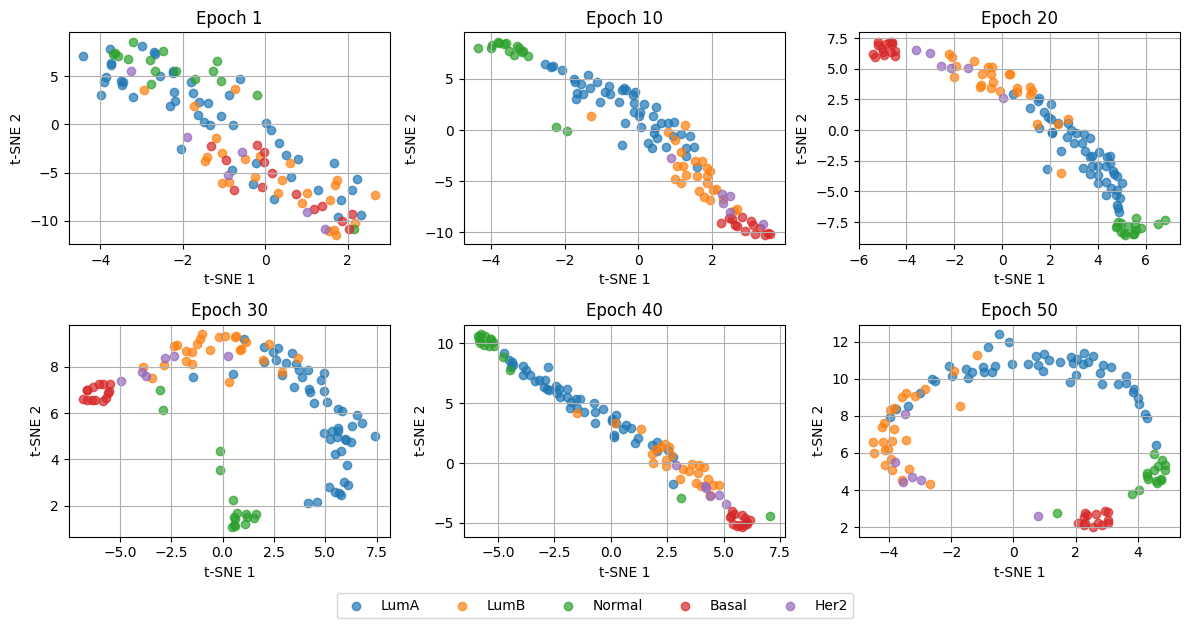

In [20]:
plot_tsne(tsne_path=GOOGLE_DRIVE_PATH + "/logs/rna_seq_cnn/tsne_results_{0}.pkl".format(model_no), epochs=[1, 10, 20, 30, 40, 50], figsize=(4,3))

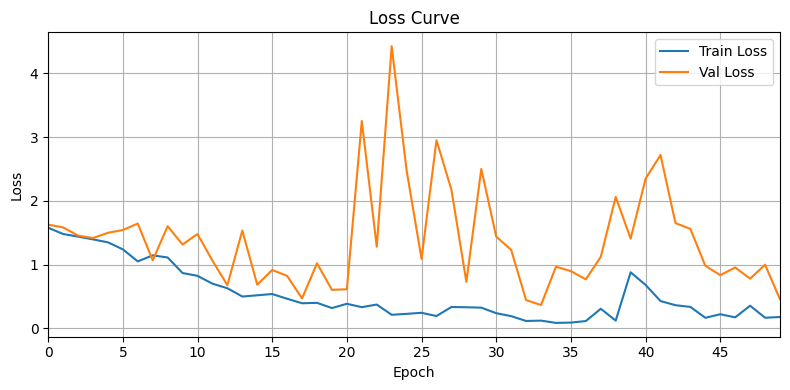

In [21]:
plot_loss(loss_path=GOOGLE_DRIVE_PATH + "/logs/rna_seq_cnn/loss_history_{0}.json".format(model_no), figsize=(8, 4))

In [22]:
# for name, param in multiomics_model.named_parameters():
#     print(name, param.grad is not None)

In [23]:
model_no=1
loss_fn = RNASeqLoss(
    beta=0.1,               # Target KL weight
    annealing_steps=5000,   # Total steps to anneal over
    use_focal=True,
    focal_gamma=1,
    label_smoothing=0.1,
    class_weights=torch.tensor([1.0, 2.5, 1.0, 1.0, 1.5], device=device) # or torch.tensor([...], device="cuda")
)


rna_exp_dim = 13054
latent_dim = 32
num_classes = 5

# Instantiate model
singleomics_model = SingleOmicsClassifierCNN(
    rna_exp_dim=rna_exp_dim,
    latent_dim=latent_dim,
    num_classes=num_classes
)



loss_callback = LossRecorderCallback(save_path=GOOGLE_DRIVE_PATH + "/logs/rna_seq_cnn/loss_history_{0}.json".format(model_no))
tsne_callback = TSNERecorderCallbackSingleOmic(
    val_loader=dataloaders['val'],  # Your validation DataLoader
    device=device,
    save_path=GOOGLE_DRIVE_PATH + "/logs/rna_seq_cnn/tsne_results_{0}.pkl".format(model_no)  # Matches your plot_tsne() default
)

trainer_cb = CallbackTrainer(
    model=singleomics_model,
    optimizer=torch.optim.Adam(singleomics_model.parameters(), lr=2e-4),
    loss_fn=loss_fn,
    device=device,
    callbacks=[loss_callback, tsne_callback],
    seed=42
)

trainer_cb.fit(train_loader=dataloaders['train'], val_loader=dataloaders['val'], epochs=50)

/content/drive/MyDrive/final_project/losses/focal.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer('weight', torch.tensor(weight) if weight is not None else None)



Epoch 1/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  3.56it/s, loss=1.62]


Train Loss: 1.8466


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.64it/s]

Val Loss:   1.9545



Epoch 2/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training:  80%|████████  | 4/5 [00:00<00:00,  4.70it/s, loss=1.64]

step    10 | loss: 1.7258 | ce: 1.7258 | kl: 0.0000 | beta: 0.0076


Training: 100%|██████████| 5/5 [00:01<00:00,  4.62it/s, loss=1.57]


Train Loss: 1.7398


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.79it/s]

Val Loss:   1.9276



Epoch 3/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  3.91it/s, loss=1.29]


Train Loss: 1.6215


Validation: 100%|██████████| 2/2 [00:00<00:00,  3.79it/s]

Val Loss:   1.7510



Epoch 4/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  3.96it/s, loss=1.75]


Train Loss: 1.6376


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.30it/s]

Val Loss:   1.7598



Epoch 5/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training:  60%|██████    | 3/5 [00:00<00:00,  4.23it/s, loss=1.49]

step    30 | loss: 1.5132 | ce: 1.5132 | kl: 0.0000 | beta: 0.0078


Training: 100%|██████████| 5/5 [00:01<00:00,  4.52it/s, loss=1.53]


Train Loss: 1.5544


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.24it/s]

Val Loss:   1.7229



Epoch 6/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  4.48it/s, loss=1.11]


step    40 | loss: 1.1143 | ce: 1.1143 | kl: 0.0000 | beta: 0.0079
Train Loss: 1.3842


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.51it/s]

Val Loss:   2.0927



Epoch 7/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  4.56it/s, loss=1.45]


Train Loss: 1.3632


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.52it/s]

Val Loss:   1.9677



Epoch 8/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training:  40%|████      | 2/5 [00:00<00:00,  3.58it/s, loss=1.31]

step    50 | loss: 1.1921 | ce: 1.1921 | kl: 0.0000 | beta: 0.0079


Training: 100%|██████████| 5/5 [00:01<00:00,  4.53it/s, loss=1.24]


Train Loss: 1.2544


Validation: 100%|██████████| 2/2 [00:00<00:00,  3.60it/s]

Val Loss:   2.0029



Epoch 9/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  3.68it/s, loss=1.09]


step    60 | loss: 1.0983 | ce: 1.0983 | kl: 0.0000 | beta: 0.0080
Train Loss: 1.0691


Validation: 100%|██████████| 2/2 [00:00<00:00,  3.40it/s]

Val Loss:   2.3352



Epoch 10/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  4.21it/s, loss=1.38]


Train Loss: 1.1614


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.18it/s]

Val Loss:   1.2227



Epoch 11/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  4.53it/s, loss=1.18]


Train Loss: 0.9951


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.44it/s]

Val Loss:   1.0486



Epoch 12/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training:  80%|████████  | 4/5 [00:00<00:00,  4.76it/s, loss=0.829]

step    80 | loss: 0.9615 | ce: 0.9615 | kl: 0.0000 | beta: 0.0082


Training: 100%|██████████| 5/5 [00:01<00:00,  4.65it/s, loss=0.917]


Train Loss: 0.8678


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.32it/s]

Val Loss:   1.6161



Epoch 13/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  4.63it/s, loss=0.774]


Train Loss: 0.7302


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.50it/s]

Val Loss:   2.5333



Epoch 14/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  3.64it/s, loss=0.546]


Train Loss: 0.6491


Validation: 100%|██████████| 2/2 [00:00<00:00,  3.57it/s]

Val Loss:   0.8903



Epoch 15/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training:  60%|██████    | 3/5 [00:00<00:00,  3.73it/s, loss=0.657]

step   100 | loss: 0.6898 | ce: 0.6898 | kl: 0.0000 | beta: 0.0083


Training: 100%|██████████| 5/5 [00:01<00:00,  4.01it/s, loss=0.657]


Train Loss: 0.6929


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.12it/s]

Val Loss:   1.1780



Epoch 16/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  4.67it/s, loss=0.587]


step   110 | loss: 0.5867 | ce: 0.5867 | kl: 0.0000 | beta: 0.0084
Train Loss: 0.6971


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.40it/s]

Val Loss:   0.9222



Epoch 17/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  4.52it/s, loss=0.528]


Train Loss: 0.5717


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.60it/s]

Val Loss:   1.2770



Epoch 18/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training:  40%|████      | 2/5 [00:00<00:00,  3.57it/s, loss=0.531]

step   120 | loss: 0.5786 | ce: 0.5786 | kl: 0.0000 | beta: 0.0085


Training: 100%|██████████| 5/5 [00:01<00:00,  4.54it/s, loss=0.335]


Train Loss: 0.5070


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.67it/s]

Val Loss:   2.5451



Epoch 19/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  4.27it/s, loss=3.32]

step   130 | loss: 0.4656 | ce: 0.4656 | kl: 0.0000 | beta: 0.0085


Train Loss: 1.0642


Validation: 100%|██████████| 2/2 [00:00<00:00,  3.41it/s]

Val Loss:   1.5275



Epoch 20/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  3.70it/s, loss=1.95]


Train Loss: 1.1719


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.26it/s]

Val Loss:   2.2122



Epoch 21/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  4.58it/s, loss=0.739]


Train Loss: 0.7387


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.46it/s]

Val Loss:   2.5235



Epoch 22/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training:  80%|████████  | 4/5 [00:00<00:00,  4.66it/s, loss=0.743]

step   150 | loss: 0.7191 | ce: 0.7191 | kl: 0.0000 | beta: 0.0087


Training: 100%|██████████| 5/5 [00:01<00:00,  4.54it/s, loss=1.66]


Train Loss: 0.9467


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.52it/s]

Val Loss:   1.2465



Epoch 23/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  4.54it/s, loss=0.656]


Train Loss: 0.6809


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.51it/s]

Val Loss:   1.5459



Epoch 24/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  4.44it/s, loss=0.446]


Train Loss: 0.5813


Validation: 100%|██████████| 2/2 [00:00<00:00,  3.79it/s]

Val Loss:   1.2220



Epoch 25/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training:  60%|██████    | 3/5 [00:01<00:00,  3.39it/s, loss=0.56]

step   170 | loss: 0.4690 | ce: 0.4690 | kl: 0.0000 | beta: 0.0089


Training: 100%|██████████| 5/5 [00:01<00:00,  3.52it/s, loss=0.844]


Train Loss: 0.6118


Validation: 100%|██████████| 2/2 [00:00<00:00,  3.99it/s]

Val Loss:   2.0219



Epoch 26/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  4.33it/s, loss=0.746]


step   180 | loss: 0.7464 | ce: 0.7464 | kl: 0.0000 | beta: 0.0089
Train Loss: 0.5483


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.58it/s]

Val Loss:   0.7514



Epoch 27/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  4.60it/s, loss=0.592]


Train Loss: 0.5129


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.55it/s]

Val Loss:   1.4720



Epoch 28/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training:  40%|████      | 2/5 [00:00<00:00,  3.50it/s, loss=0.458]

step   190 | loss: 0.6350 | ce: 0.6350 | kl: 0.0000 | beta: 0.0090


Training: 100%|██████████| 5/5 [00:01<00:00,  4.44it/s, loss=0.554]


Train Loss: 0.5081


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.39it/s]

Val Loss:   0.8507



Epoch 29/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  4.49it/s, loss=0.569]


step   200 | loss: 0.4217 | ce: 0.4217 | kl: 0.0000 | beta: 0.0091
Train Loss: 0.4490


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.47it/s]

Val Loss:   0.7598



Epoch 30/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  3.34it/s, loss=0.786]


Train Loss: 0.4816


Validation: 100%|██████████| 2/2 [00:00<00:00,  3.50it/s]

Val Loss:   1.1490



Epoch 31/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  4.24it/s, loss=1.25]


Train Loss: 0.5780


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.39it/s]

Val Loss:   0.8893



Epoch 32/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training:  80%|████████  | 4/5 [00:00<00:00,  4.62it/s, loss=0.591]

step   220 | loss: 0.4173 | ce: 0.4173 | kl: 0.0000 | beta: 0.0093


Training: 100%|██████████| 5/5 [00:01<00:00,  4.49it/s, loss=0.38]


Train Loss: 0.4681


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.73it/s]

Val Loss:   0.9352



Epoch 33/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  4.23it/s, loss=0.454]


Train Loss: 0.4448


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.04it/s]

Val Loss:   1.8348



Epoch 34/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  4.43it/s, loss=0.634]


Train Loss: 0.4553


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.21it/s]

Val Loss:   2.0214



Epoch 35/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training:  60%|██████    | 3/5 [00:00<00:00,  4.10it/s, loss=0.393]

step   240 | loss: 0.3319 | ce: 0.3319 | kl: 0.0000 | beta: 0.0094


Training: 100%|██████████| 5/5 [00:01<00:00,  4.08it/s, loss=0.602]


Train Loss: 0.4219


Validation: 100%|██████████| 2/2 [00:00<00:00,  3.44it/s]

Val Loss:   1.2450



Epoch 36/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  3.67it/s, loss=0.994]


step   250 | loss: 0.9944 | ce: 0.9944 | kl: 0.0000 | beta: 0.0095
Train Loss: 0.5351


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.95it/s]

Val Loss:   0.6592



Epoch 37/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  4.11it/s, loss=0.622]


Train Loss: 0.4460


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.11it/s]

Val Loss:   0.7552



Epoch 38/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training:  40%|████      | 2/5 [00:00<00:00,  3.30it/s, loss=0.327]

step   260 | loss: 0.4387 | ce: 0.4387 | kl: 0.0000 | beta: 0.0096


Training: 100%|██████████| 5/5 [00:01<00:00,  4.24it/s, loss=0.331]


Train Loss: 0.3689


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.85it/s]

Val Loss:   1.0294



Epoch 39/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  4.25it/s, loss=0.876]


step   270 | loss: 0.3668 | ce: 0.3668 | kl: 0.0000 | beta: 0.0097
Train Loss: 0.4557


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.20it/s]

Val Loss:   0.7051



Epoch 40/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  4.26it/s, loss=0.336]


Train Loss: 0.3639


Validation: 100%|██████████| 2/2 [00:00<00:00,  2.97it/s]

Val Loss:   0.6707



Epoch 41/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  3.49it/s, loss=0.335]


Train Loss: 0.3819


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.41it/s]

Val Loss:   0.8176



Epoch 42/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training:  80%|████████  | 4/5 [00:01<00:00,  4.50it/s, loss=0.333]

step   290 | loss: 0.3302 | ce: 0.3302 | kl: 0.0000 | beta: 0.0099


Training: 100%|██████████| 5/5 [00:01<00:00,  4.38it/s, loss=0.461]


Train Loss: 0.3668


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.29it/s]

Val Loss:   0.6316



Epoch 43/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  4.37it/s, loss=0.522]


Train Loss: 0.3891


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.38it/s]

Val Loss:   0.8445



Epoch 44/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  4.42it/s, loss=0.766]


Train Loss: 0.4527


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.48it/s]

Val Loss:   0.9380



Epoch 45/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training:  60%|██████    | 3/5 [00:00<00:00,  3.75it/s, loss=0.401]

step   310 | loss: 0.3171 | ce: 0.3171 | kl: 0.0000 | beta: 0.0101


Training: 100%|██████████| 5/5 [00:01<00:00,  3.82it/s, loss=1.69]


Train Loss: 0.6568


Validation: 100%|██████████| 2/2 [00:00<00:00,  3.25it/s]

Val Loss:   0.7244



Epoch 46/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  3.48it/s, loss=0.444]


step   320 | loss: 0.4441 | ce: 0.4441 | kl: 0.0000 | beta: 0.0101
Train Loss: 0.3693


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.31it/s]

Val Loss:   2.1968



Epoch 47/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  4.29it/s, loss=0.535]


Train Loss: 0.4101


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.98it/s]

Val Loss:   1.9946



Epoch 48/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training:  40%|████      | 2/5 [00:00<00:00,  3.23it/s, loss=0.362]

step   330 | loss: 0.3423 | ce: 0.3423 | kl: 0.0000 | beta: 0.0102


Training: 100%|██████████| 5/5 [00:01<00:00,  4.19it/s, loss=0.4]


Train Loss: 0.3740


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.76it/s]

Val Loss:   0.8504



Epoch 49/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  4.29it/s, loss=0.281]


step   340 | loss: 0.3584 | ce: 0.3584 | kl: 0.0000 | beta: 0.0103
Train Loss: 0.3172


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.98it/s]

Val Loss:   0.7667



Epoch 50/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  4.17it/s, loss=0.28]


Train Loss: 0.3211


Validation: 100%|██████████| 2/2 [00:00<00:00,  3.10it/s]

Val Loss:   0.6325


In [24]:
preds, targets = trainer_cb.predict(dataloaders["test"])
acc = accuracy_score(targets.numpy(), preds.numpy())
print(f"✅ Test Accuracy: {acc:.4f}")

print(classification_report(targets.numpy(), preds.numpy()))
params = get_training_parameters(trainer_cb)

print(json.dumps(params, indent=4))

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Test Accuracy: 0.7879
              precision    recall  f1-score   support

           0       0.79      0.79      0.79        29
           1       0.69      0.60      0.64        15
           2       0.82      1.00      0.90         9
           3       0.82      1.00      0.90         9
           4       1.00      0.50      0.67         4

    accuracy                           0.79        66
   macro avg       0.82      0.78      0.78        66
weighted avg       0.79      0.79      0.78        66

{
    "training": {
        "device": "cuda"
    },
    "loss": {
        "type": "RNASeqLoss",
        "beta": 0.1,
        "use_focal": true,
        "focal_gamma": 1,
        "label_smoothing": 0.1,
        "kl_epsilon": 1e-08
    },
    "optimizer": {
        "type": "Adam",
        "lr": 0.0002,
        "betas": [
            0.9,
            0.999
        ],
        "eps": 1e-08,
        "weight_decay": 0
    }
}


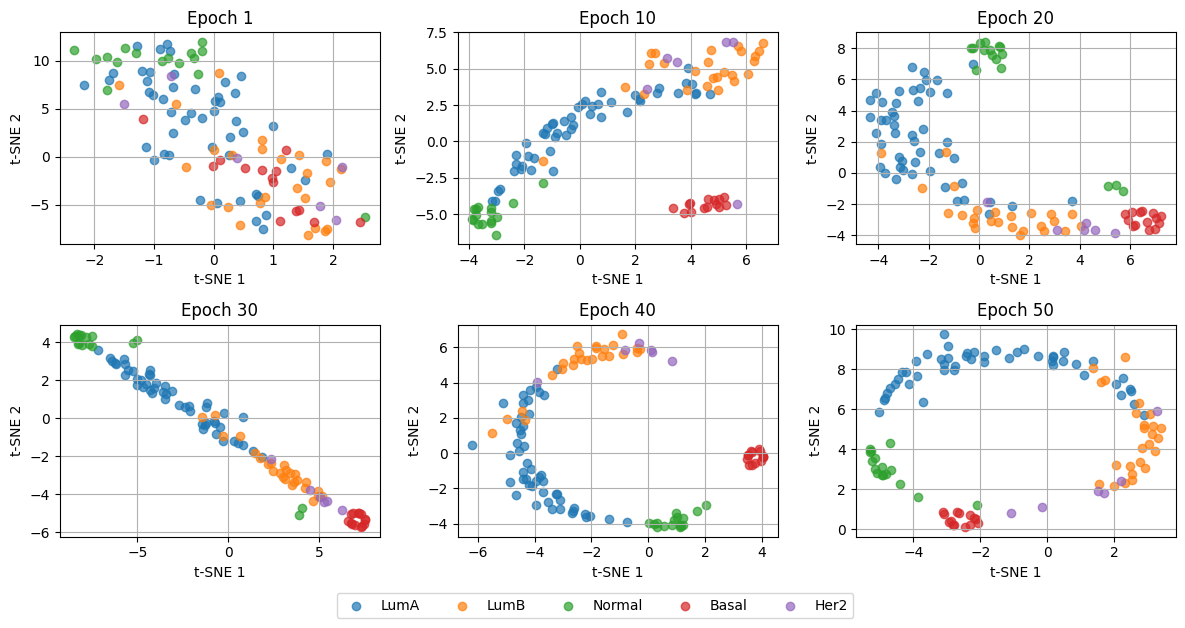

In [25]:
plot_tsne(tsne_path=GOOGLE_DRIVE_PATH + "/logs/rna_seq_cnn/tsne_results_{0}.pkl".format(model_no), epochs=[1, 10, 20, 30, 40, 50], cols=3, figsize=(4, 3))

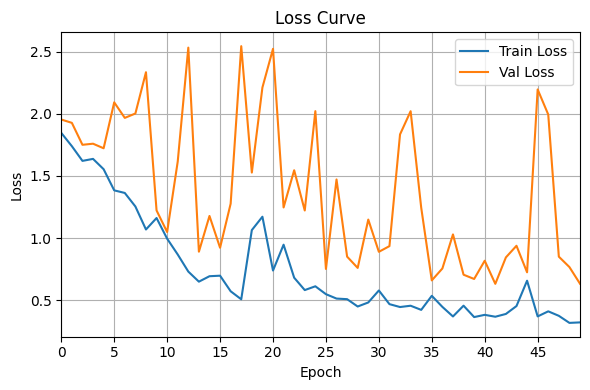

In [26]:
plot_loss(loss_path=GOOGLE_DRIVE_PATH + "/logs/rna_seq_cnn/loss_history_{0}.json".format(model_no), figsize=(6, 4))

In [27]:
model_no=2
loss_fn = RNASeqLoss(
    beta=0.2,               # Target KL weight
    # annealing_steps=5000,   # Total steps to anneal over
    use_focal=True,
    focal_gamma=2.5,
    label_smoothing=0,
    class_weights=torch.tensor([1.0, 1.0, 1.0, 1.5, 2.5], device=device) # or torch.tensor([...], device="cuda")
)

rna_exp_dim = 13054
latent_dim = 64
num_classes = 5

# Instantiate model
singleomics_model = SingleOmicsClassifierCNN(
    rna_exp_dim=rna_exp_dim,
    latent_dim=latent_dim,
    num_classes=num_classes
)




loss_callback = LossRecorderCallback(save_path=GOOGLE_DRIVE_PATH + "/logs/rna_seq_cnn/loss_history_{0}.json".format(model_no))
acc_callback = AccuracyRecorderCallback(save_path=Path(GOOGLE_DRIVE_PATH + "/logs/rna_seq_cnn/accuracy_history_{0}.json".format(model_no)))

tsne_callback = TSNERecorderCallbackSingleOmic(
    val_loader=dataloaders['val'],  # Your validation DataLoader
    device=device,
    save_path=GOOGLE_DRIVE_PATH + "/logs/rna_seq_cnn/tsne_results_{0}.pkl".format(model_no)  # Matches your plot_tsne() default
)



trainer_cb = CallbackTrainer(
    model=singleomics_model,
    optimizer=torch.optim.AdamW(singleomics_model.parameters(), lr=2e-4, weight_decay=0.0001),
    loss_fn=loss_fn,
    device=device,
    callbacks=[loss_callback, acc_callback, tsne_callback],
    seed=42
)

trainer_cb.fit(train_loader=dataloaders['train'], val_loader=dataloaders['val'], epochs=40)

/content/drive/MyDrive/final_project/losses/focal.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer('weight', torch.tensor(weight) if weight is not None else None)



Epoch 1/40


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  4.08it/s, loss=1]


Train Loss: 1.1308


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.04it/s]

Val Loss:   1.2500


✅ Val Accuracy: 0.1273


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



Epoch 2/40


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training:  80%|████████  | 4/5 [00:01<00:00,  4.26it/s, loss=1.01]

step    10 | loss: 1.1901 | ce: 1.1901 | kl: 0.0000 | beta: 0.0152


Training: 100%|██████████| 5/5 [00:01<00:00,  4.05it/s, loss=0.856]


Train Loss: 1.0544


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.93it/s]

Val Loss:   1.2610


✅ Val Accuracy: 0.1273


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



Epoch 3/40


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  3.87it/s, loss=1.27]


Train Loss: 1.0967


Validation: 100%|██████████| 2/2 [00:00<00:00,  3.07it/s]

Val Loss:   1.2543


✅ Val Accuracy: 0.1273


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



Epoch 4/40


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  4.13it/s, loss=1.73]


Train Loss: 1.1478


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.46it/s]

Val Loss:   1.0537


✅ Val Accuracy: 0.4818


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



Epoch 5/40


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training:  60%|██████    | 3/5 [00:00<00:00,  3.83it/s, loss=0.951]

step    30 | loss: 0.9521 | ce: 0.9521 | kl: 0.0000 | beta: 0.0154


Training: 100%|██████████| 5/5 [00:01<00:00,  4.11it/s, loss=0.69]


Train Loss: 0.9276


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.30it/s]

Val Loss:   1.2311


✅ Val Accuracy: 0.4455


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



Epoch 6/40


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  4.21it/s, loss=0.691]


step    40 | loss: 0.6914 | ce: 0.6914 | kl: 0.0000 | beta: 0.0154
Train Loss: 0.8781


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.99it/s]

Val Loss:   1.2997


✅ Val Accuracy: 0.4455


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



Epoch 7/40


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  4.13it/s, loss=0.537]


Train Loss: 0.7413


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.64it/s]

Val Loss:   1.3952


✅ Val Accuracy: 0.4455


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



Epoch 8/40


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training:  40%|████      | 2/5 [00:00<00:01,  2.47it/s, loss=0.792]

step    50 | loss: 0.5787 | ce: 0.5787 | kl: 0.0000 | beta: 0.0155


Training: 100%|██████████| 5/5 [00:01<00:00,  3.46it/s, loss=0.874]


Train Loss: 0.6759


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.35it/s]

Val Loss:   1.0968


✅ Val Accuracy: 0.4545


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



Epoch 9/40


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  4.08it/s, loss=0.444]


step    60 | loss: 0.4228 | ce: 0.4228 | kl: 0.0000 | beta: 0.0156
Train Loss: 0.5471


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.32it/s]

Val Loss:   1.6799


✅ Val Accuracy: 0.4455


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



Epoch 10/40


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  4.06it/s, loss=0.274]


Train Loss: 0.4533


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.10it/s]

Val Loss:   0.7718


✅ Val Accuracy: 0.5818


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



Epoch 11/40


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  4.22it/s, loss=0.257]


Train Loss: 0.3533


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.57it/s]

Val Loss:   1.9896


✅ Val Accuracy: 0.4455


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



Epoch 12/40


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training:  80%|████████  | 4/5 [00:01<00:00,  3.73it/s, loss=0.387]

step    80 | loss: 0.2664 | ce: 0.2664 | kl: 0.0000 | beta: 0.0157


Training: 100%|██████████| 5/5 [00:01<00:00,  3.29it/s, loss=0.184]


Train Loss: 0.3089


Validation: 100%|██████████| 2/2 [00:00<00:00,  3.61it/s]

Val Loss:   0.4528


✅ Val Accuracy: 0.6636


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



Epoch 13/40


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  4.14it/s, loss=0.478]


Train Loss: 0.3278


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.46it/s]

Val Loss:   0.6334


✅ Val Accuracy: 0.7273


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



Epoch 14/40


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  4.03it/s, loss=0.667]


Train Loss: 0.4181


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.29it/s]

Val Loss:   1.7926


✅ Val Accuracy: 0.4636


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



Epoch 15/40


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training:  60%|██████    | 3/5 [00:00<00:00,  3.84it/s, loss=0.342]

step   100 | loss: 0.3573 | ce: 0.3573 | kl: 0.0000 | beta: 0.0159


Training: 100%|██████████| 5/5 [00:01<00:00,  4.13it/s, loss=0.21]


Train Loss: 0.3325


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.35it/s]

Val Loss:   0.9889


✅ Val Accuracy: 0.5091


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



Epoch 16/40


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  3.84it/s, loss=0.0291]


step   110 | loss: 0.0291 | ce: 0.0291 | kl: 0.0000 | beta: 0.0160
Train Loss: 0.2121


Validation: 100%|██████████| 2/2 [00:00<00:00,  3.12it/s]

Val Loss:   1.3361


✅ Val Accuracy: 0.4182


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



Epoch 17/40


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  3.60it/s, loss=0.284]


Train Loss: 0.1954


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.05it/s]

Val Loss:   0.4500


✅ Val Accuracy: 0.6818


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



Epoch 18/40


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training:  40%|████      | 2/5 [00:00<00:00,  3.21it/s, loss=0.148]

step   120 | loss: 0.2474 | ce: 0.2474 | kl: 0.0000 | beta: 0.0160


Training: 100%|██████████| 5/5 [00:01<00:00,  4.13it/s, loss=0.198]


Train Loss: 0.1879


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.22it/s]

Val Loss:   0.3902


✅ Val Accuracy: 0.7091


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



Epoch 19/40


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  4.04it/s, loss=0.169]


step   130 | loss: 0.1038 | ce: 0.1038 | kl: 0.0000 | beta: 0.0161
Train Loss: 0.1247


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.92it/s]

Val Loss:   0.3499


✅ Val Accuracy: 0.8364


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



Epoch 20/40


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  4.08it/s, loss=0.301]


Train Loss: 0.1439


Validation: 100%|██████████| 2/2 [00:00<00:00,  3.90it/s]

Val Loss:   0.5418


✅ Val Accuracy: 0.8182


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



Epoch 21/40


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  3.40it/s, loss=0.284]


Train Loss: 0.1386


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.39it/s]

Val Loss:   1.7046


✅ Val Accuracy: 0.4727


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



Epoch 22/40


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training:  60%|██████    | 3/5 [00:01<00:00,  3.83it/s, loss=0.393] 

step   150 | loss: 0.0776 | ce: 0.0776 | kl: 0.0000 | beta: 0.0162


Training: 100%|██████████| 5/5 [00:01<00:00,  4.10it/s, loss=0.0338]


Train Loss: 0.1563


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.77it/s]

Val Loss:   0.3610


✅ Val Accuracy: 0.7545


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



Epoch 23/40


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  3.81it/s, loss=0.0849]


Train Loss: 0.0904


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.94it/s]

Val Loss:   0.4945


✅ Val Accuracy: 0.5818


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



Epoch 24/40


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  4.02it/s, loss=0.119]


Train Loss: 0.0740


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.86it/s]

Val Loss:   0.5320


✅ Val Accuracy: 0.7364


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



Epoch 25/40


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training:  60%|██████    | 3/5 [00:01<00:00,  3.22it/s, loss=0.0474]

step   170 | loss: 0.0596 | ce: 0.0596 | kl: 0.0000 | beta: 0.0164


Training: 100%|██████████| 5/5 [00:01<00:00,  3.33it/s, loss=0.246]


Train Loss: 0.1046


Validation: 100%|██████████| 2/2 [00:00<00:00,  3.25it/s]

Val Loss:   0.5159


✅ Val Accuracy: 0.8455


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



Epoch 26/40


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  3.93it/s, loss=0.0644]


step   180 | loss: 0.0644 | ce: 0.0644 | kl: 0.0000 | beta: 0.0165
Train Loss: 0.0820


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.09it/s]

Val Loss:   0.5802


✅ Val Accuracy: 0.7091


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



Epoch 27/40


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  4.10it/s, loss=0.0639]


Train Loss: 0.0586


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.19it/s]

Val Loss:   0.5233


✅ Val Accuracy: 0.6000


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



Epoch 28/40


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training:  40%|████      | 2/5 [00:00<00:00,  3.09it/s, loss=0.0312]

step   190 | loss: 0.0186 | ce: 0.0186 | kl: 0.0000 | beta: 0.0166


Training: 100%|██████████| 5/5 [00:01<00:00,  4.04it/s, loss=0.124]


Train Loss: 0.0506


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.18it/s]

Val Loss:   0.6101


✅ Val Accuracy: 0.6909


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



Epoch 29/40


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training:  80%|████████  | 4/5 [00:01<00:00,  3.94it/s, loss=0.172]

step   200 | loss: 0.2030 | ce: 0.2030 | kl: 0.0000 | beta: 0.0166


Training: 100%|██████████| 5/5 [00:01<00:00,  3.52it/s, loss=0.172]


Train Loss: 0.1152


Validation: 100%|██████████| 2/2 [00:00<00:00,  3.18it/s]

Val Loss:   0.3139


✅ Val Accuracy: 0.8182


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



Epoch 30/40


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  4.06it/s, loss=0.913]


Train Loss: 0.2683


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.85it/s]

Val Loss:   1.4579


✅ Val Accuracy: 0.3545


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



Epoch 31/40


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  4.08it/s, loss=0.422]


Train Loss: 0.2523


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.04it/s]

Val Loss:   1.2708


✅ Val Accuracy: 0.3273


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



Epoch 32/40


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training:  80%|████████  | 4/5 [00:01<00:00,  4.34it/s, loss=0.175]

step   220 | loss: 0.7574 | ce: 0.7574 | kl: 0.0000 | beta: 0.0168


Training: 100%|██████████| 5/5 [00:01<00:00,  4.24it/s, loss=0.291]


Train Loss: 0.3324


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.09it/s]

Val Loss:   4.8506


✅ Val Accuracy: 0.2273


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



Epoch 33/40


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  3.90it/s, loss=0.219]


Train Loss: 0.3345


Validation: 100%|██████████| 2/2 [00:00<00:00,  3.38it/s]

Val Loss:   2.2351


✅ Val Accuracy: 0.3000


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



Epoch 34/40


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  3.56it/s, loss=0.0574]


Train Loss: 0.1161


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.06it/s]

Val Loss:   0.5316


✅ Val Accuracy: 0.7000


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



Epoch 35/40


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training:  60%|██████    | 3/5 [00:00<00:00,  3.77it/s, loss=0.108]

step   240 | loss: 0.0632 | ce: 0.0632 | kl: 0.0000 | beta: 0.0169


Training: 100%|██████████| 5/5 [00:01<00:00,  4.06it/s, loss=0.0638]


Train Loss: 0.1039


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.23it/s]

Val Loss:   0.3949


✅ Val Accuracy: 0.8091


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



Epoch 36/40


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  4.06it/s, loss=0.0126]


step   250 | loss: 0.0126 | ce: 0.0126 | kl: 0.0000 | beta: 0.0170
Train Loss: 0.0713


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.20it/s]

Val Loss:   0.2978


✅ Val Accuracy: 0.7636


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



Epoch 37/40


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  4.03it/s, loss=0.0608]


Train Loss: 0.0479


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.32it/s]

Val Loss:   0.3730


✅ Val Accuracy: 0.7000


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



Epoch 38/40


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training:  40%|████      | 2/5 [00:00<00:01,  2.37it/s, loss=0.0402]

step   260 | loss: 0.0477 | ce: 0.0477 | kl: 0.0000 | beta: 0.0171


Training: 100%|██████████| 5/5 [00:01<00:00,  3.25it/s, loss=0.0265]


Train Loss: 0.0418


Validation: 100%|██████████| 2/2 [00:00<00:00,  3.05it/s]

Val Loss:   0.3316


✅ Val Accuracy: 0.8727


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



Epoch 39/40


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  3.99it/s, loss=0.0866]


step   270 | loss: 0.0208 | ce: 0.0208 | kl: 0.0000 | beta: 0.0172
Train Loss: 0.0375


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.90it/s]

Val Loss:   0.4589


✅ Val Accuracy: 0.8364


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



Epoch 40/40


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  4.00it/s, loss=0.00817]


Train Loss: 0.0332


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.99it/s]

Val Loss:   0.3326


✅ Val Accuracy: 0.8182


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [28]:
from utils import set_seed
set_seed(42)
preds, targets = trainer_cb.predict(dataloaders["test"])
acc = accuracy_score(targets.numpy(), preds.numpy())
print(f"✅ Test Accuracy: {acc:.4f}")

print(classification_report(targets.numpy(), preds.numpy()))
params = get_training_parameters(trainer_cb)

print(json.dumps(params, indent=4))

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Test Accuracy: 0.8333
              precision    recall  f1-score   support

           0       0.92      0.76      0.83        29
           1       0.71      0.80      0.75        15
           2       0.82      1.00      0.90         9
           3       0.90      1.00      0.95         9
           4       0.75      0.75      0.75         4

    accuracy                           0.83        66
   macro avg       0.82      0.86      0.84        66
weighted avg       0.84      0.83      0.83        66

{
    "training": {
        "device": "cuda"
    },
    "loss": {
        "type": "RNASeqLoss",
        "beta": 0.2,
        "use_focal": true,
        "focal_gamma": 2.5,
        "label_smoothing": 0,
        "kl_epsilon": 1e-08
    },
    "optimizer": {
        "type": "AdamW",
        "lr": 0.0002,
        "betas": [
            0.9,
            0.999
        ],
        "eps": 1e-08,
        "weight_decay": 0.0001
    }
}


In [29]:
import numpy as np
from sklearn.metrics import accuracy_score
from utils import set_seed
import torch

def evaluate_multiple_seeds(trainer, test_loader, seeds=100):
    accs = []

    for seed in np.random.randint(0, 10_000, size=seeds):
        set_seed(int(seed))  # Reset seed
        preds, targets = trainer.predict(test_loader)
        acc = accuracy_score(targets.numpy(), preds.numpy())
        accs.append(acc)

    accs = np.array(accs)
    print(f"\n✅ Avg Accuracy over {seeds} seeds: {accs.mean():.4f} ± {accs.std():.4f}")
    return accs
accs = evaluate_multiple_seeds(trainer_cb, dataloaders["test"], seeds=100)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: T


✅ Avg Accuracy over 100 seeds: 0.8333 ± 0.0000


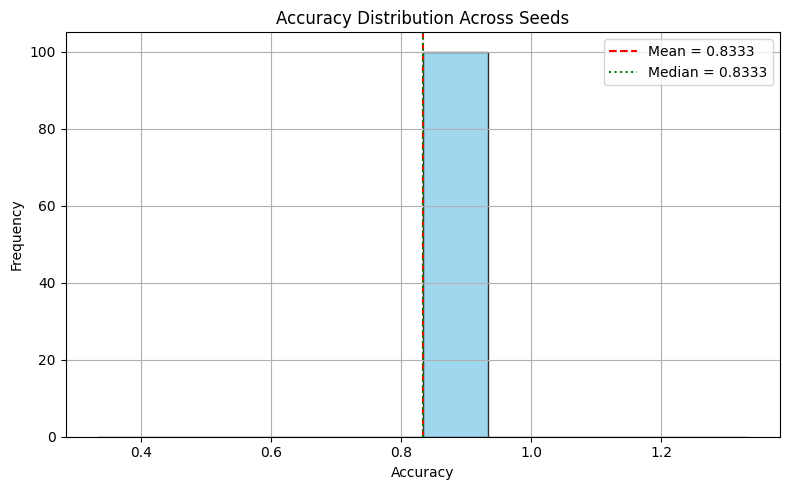

In [30]:
import matplotlib.pyplot as plt
import numpy as np

def plot_accuracy_distribution(accs, bins=10, title="Accuracy Distribution Across Seeds"):
    plt.figure(figsize=(8, 5))
    plt.hist(accs, bins=bins, color="skyblue", edgecolor="black", alpha=0.8)
    plt.axvline(np.mean(accs), color='red', linestyle='--', label=f"Mean = {np.mean(accs):.4f}")
    plt.axvline(np.median(accs), color='green', linestyle=':', label=f"Median = {np.median(accs):.4f}")

    plt.title(title)
    plt.xlabel("Accuracy")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
plot_accuracy_distribution(accs)

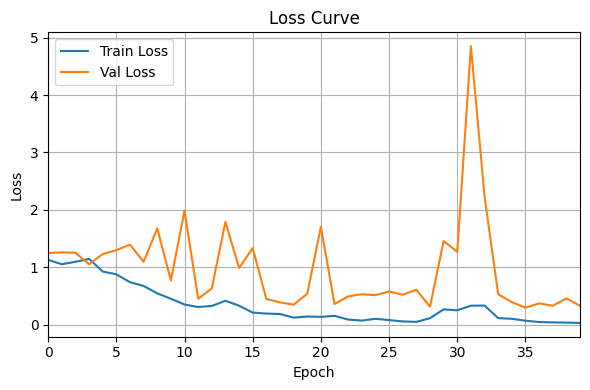

In [31]:
plot_loss(loss_path=GOOGLE_DRIVE_PATH + "/logs/rna_seq_cnn/loss_history_{0}.json".format(model_no), figsize=(6, 4))

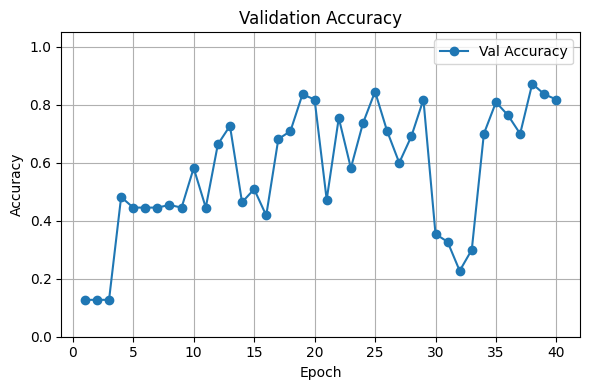

In [32]:
from utils import plot_accuracy
plot_accuracy(GOOGLE_DRIVE_PATH + "/logs/rna_seq_cnn/accuracy_history_{0}.json".format(model_no), figsize=(6, 4))

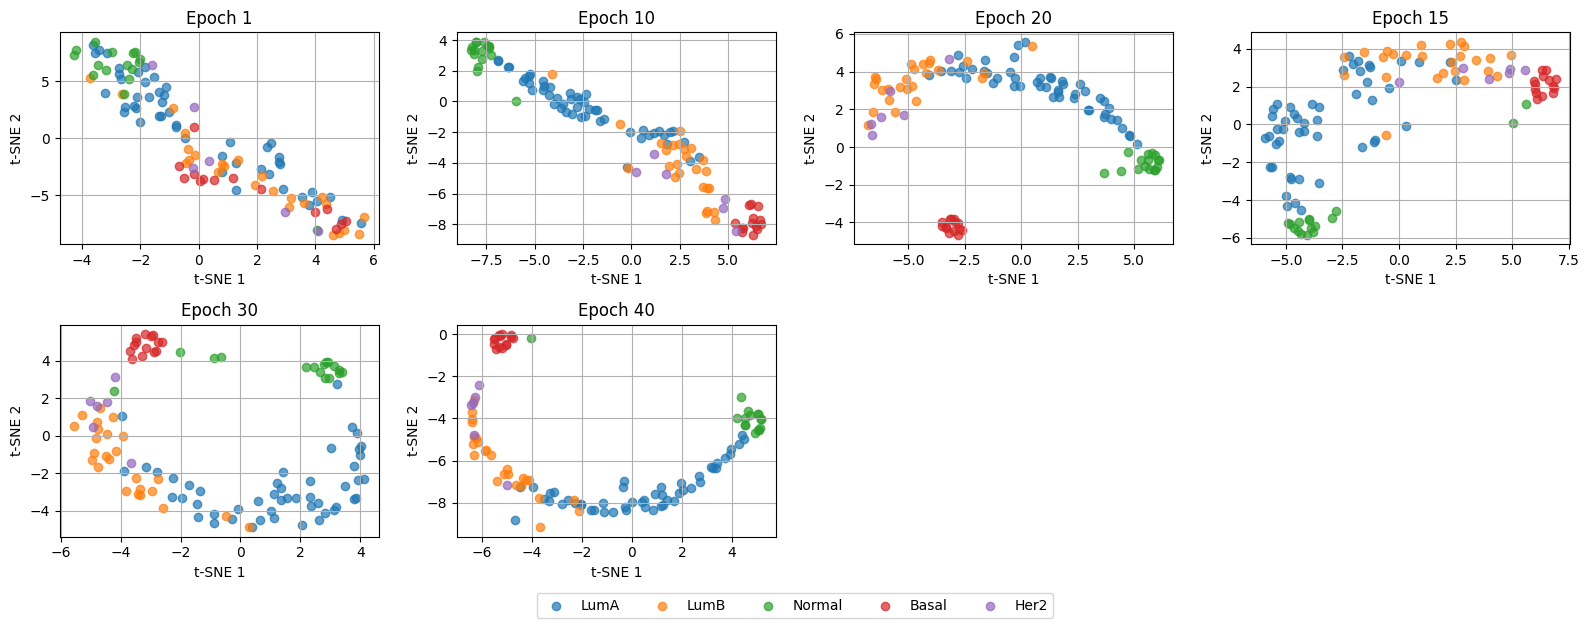

In [33]:
plot_tsne(tsne_path=GOOGLE_DRIVE_PATH + "/logs/rna_seq_cnn/tsne_results_{0}.pkl".format(model_no), epochs=[1, 10, 20, 15, 30, 40, 45, 50], cols=4, figsize=(4, 3))

In [34]:
preds, targets, logits = trainer_cb.predict(dataloaders["test"], return_logits=True)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [35]:
import torch.nn.functional as F
probs = F.softmax(logits, dim=1)
predictions = torch.argmax(probs, dim=1)

predictions

tensor([1, 1, 1, 1, 0, 2, 3, 1, 1, 3, 3, 3, 0, 1, 0, 2, 0, 0, 4, 2, 0, 1, 4, 3,
        0, 2, 0, 1, 0, 3, 1, 2, 3, 0, 0, 1, 3, 1, 1, 0, 1, 3, 2, 0, 0, 2, 2, 0,
        2, 0, 2, 1, 0, 4, 3, 1, 0, 4, 0, 1, 0, 0, 0, 0, 0, 2])

In [36]:
model_no = 3
loss_fn = RNASeqLoss(
    beta=0.1,               # Target KL weight
    # annealing_steps=5000,   # Total steps to anneal over
    use_focal=True,
    focal_gamma=2.5,
    label_smoothing=0,
    class_weights=torch.tensor([1.0, 1.0, 1.0, 1.5, 2.5], device=device) # or torch.tensor([...], device="cuda")
)

rna_exp_dim = 13054
latent_dim = 128
num_classes = 5

# Instantiate model
singleomics_model = SingleOmicsClassifierCNN(
    rna_exp_dim=rna_exp_dim,
    latent_dim=latent_dim,
    num_classes=num_classes
)




loss_callback = LossRecorderCallback(save_path=GOOGLE_DRIVE_PATH + "/logs/rna_seq_cnn/loss_history_{0}.json".format(model_no))
acc_callback = AccuracyRecorderCallback(save_path=Path(GOOGLE_DRIVE_PATH + "/logs/rna_seq_cnn/accuracy_history_{0}.json".format(model_no)))
tsne_callback = TSNERecorderCallbackSingleOmic(
    val_loader=dataloaders['val'],  # Your validation DataLoader
    device=device,
    save_path=GOOGLE_DRIVE_PATH + "/logs/rna_seq_cnn/tsne_results_{0}.pkl".format(model_no)  # Matches your plot_tsne() default
)
attn_cb = AttentionLoggerCallback(save_path=GOOGLE_DRIVE_PATH + "/logs/rna_seq_cnn/attention_weights_{0}.pkl".format(model_no), modality_names=["rna"])




trainer_cb = CallbackTrainer(
    model=singleomics_model,
    optimizer=torch.optim.AdamW(singleomics_model.parameters(), lr=1e-3, weight_decay=1e-4),
    loss_fn=loss_fn,
    device=device,
    callbacks=[loss_callback, tsne_callback, acc_callback],
    seed=42
)

trainer_cb.fit(train_loader=dataloaders['train'], val_loader=dataloaders['val'], epochs=60)

/content/drive/MyDrive/final_project/losses/focal.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer('weight', torch.tensor(weight) if weight is not None else None)



Epoch 1/60


Training: 100%|██████████| 5/5 [00:01<00:00,  3.88it/s, loss=0.844]


Train Loss: 1.0858


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.95it/s]

Val Loss:   1.2045



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.1273

Epoch 2/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training:  80%|████████  | 4/5 [00:01<00:00,  4.12it/s, loss=0.969]

step    10 | loss: 1.2484 | ce: 1.2484 | kl: 0.0000 | beta: 0.0076


Training: 100%|██████████| 5/5 [00:01<00:00,  3.90it/s, loss=0.673]


Train Loss: 0.9870


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.86it/s]

Val Loss:   1.0967



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.5455

Epoch 3/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  4.08it/s, loss=1.08]


Train Loss: 0.9152


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.64it/s]

Val Loss:   2.4401



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.4455

Epoch 4/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  3.27it/s, loss=0.858]


Train Loss: 0.7499


Validation: 100%|██████████| 2/2 [00:00<00:00,  3.20it/s]

Val Loss:   2.6357



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.1455

Epoch 5/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training:  60%|██████    | 3/5 [00:00<00:00,  3.63it/s, loss=0.648]

step    30 | loss: 0.5898 | ce: 0.5898 | kl: 0.0000 | beta: 0.0077


Training: 100%|██████████| 5/5 [00:01<00:00,  3.89it/s, loss=0.541]


Train Loss: 0.6010


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]

Val Loss:   3.6902



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.4455

Epoch 6/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  3.88it/s, loss=0.892]


step    40 | loss: 0.8916 | ce: 0.8916 | kl: 0.0000 | beta: 0.0077
Train Loss: 0.9342


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.93it/s]

Val Loss:   3.0106



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.1273

Epoch 7/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  3.91it/s, loss=0.548]


Train Loss: 0.7143


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.67it/s]

Val Loss:   0.6287



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.6091

Epoch 8/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training:  20%|██        | 1/5 [00:00<00:02,  1.37it/s, loss=0.519]

step    50 | loss: 0.5192 | ce: 0.5192 | kl: 0.0000 | beta: 0.0078


Training: 100%|██████████| 5/5 [00:01<00:00,  3.20it/s, loss=0.701]


Train Loss: 0.5642


Validation: 100%|██████████| 2/2 [00:00<00:00,  3.28it/s]

Val Loss:   0.6124



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.6091

Epoch 9/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  3.93it/s, loss=0.466]


step    60 | loss: 0.3141 | ce: 0.3141 | kl: 0.0000 | beta: 0.0078
Train Loss: 0.4440


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.82it/s]

Val Loss:   4.3063



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.1273

Epoch 10/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  4.00it/s, loss=0.214]


Train Loss: 0.4511


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.94it/s]

Val Loss:   3.3666



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.1455

Epoch 11/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  4.03it/s, loss=0.299]


Train Loss: 0.4107


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.98it/s]

Val Loss:   1.0398



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.4636

Epoch 12/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training:  60%|██████    | 3/5 [00:01<00:00,  3.10it/s, loss=0.448]

step    80 | loss: 0.4481 | ce: 0.4481 | kl: 0.0000 | beta: 0.0079


Training: 100%|██████████| 5/5 [00:01<00:00,  3.18it/s, loss=0.247]


Train Loss: 0.4925


Validation: 100%|██████████| 2/2 [00:00<00:00,  3.19it/s]

Val Loss:   5.0331



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.1273

Epoch 13/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  3.92it/s, loss=0.794]


Train Loss: 0.7598


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.80it/s]

Val Loss:   0.6335



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.6091

Epoch 14/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  3.85it/s, loss=1]


Train Loss: 0.7767


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.04it/s]

Val Loss:   0.5490



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.5727

Epoch 15/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training:  60%|██████    | 3/5 [00:00<00:00,  3.92it/s, loss=0.607]

step   100 | loss: 0.7650 | ce: 0.7650 | kl: 0.0000 | beta: 0.0079


Training: 100%|██████████| 5/5 [00:01<00:00,  4.22it/s, loss=0.26]


Train Loss: 0.6022


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.01it/s]

Val Loss:   3.9600



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.0545

Epoch 16/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  3.28it/s, loss=0.433]


step   110 | loss: 0.4326 | ce: 0.4326 | kl: 0.0000 | beta: 0.0080
Train Loss: 0.4840


Validation: 100%|██████████| 2/2 [00:00<00:00,  3.15it/s]

Val Loss:   0.4276



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.6727

Epoch 17/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  3.83it/s, loss=0.401]


Train Loss: 0.4232


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.87it/s]

Val Loss:   1.7205



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.3182

Epoch 18/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training:  40%|████      | 2/5 [00:00<00:00,  3.19it/s, loss=0.251]

step   120 | loss: 0.5709 | ce: 0.5709 | kl: 0.0000 | beta: 0.0080


Training: 100%|██████████| 5/5 [00:01<00:00,  4.15it/s, loss=0.562]


Train Loss: 0.3900


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]

Val Loss:   1.4807



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.5091

Epoch 19/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  3.96it/s, loss=0.459]


step   130 | loss: 0.2992 | ce: 0.2992 | kl: 0.0000 | beta: 0.0081
Train Loss: 0.3517


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.60it/s]

Val Loss:   1.7848



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.3182

Epoch 20/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  3.79it/s, loss=0.771]


Train Loss: 0.4063


Validation: 100%|██████████| 2/2 [00:00<00:00,  3.06it/s]

Val Loss:   2.0453



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.3091

Epoch 21/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  3.90it/s, loss=0.124]


Train Loss: 0.2626


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.99it/s]

Val Loss:   0.4591



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.8364

Epoch 22/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training:  80%|████████  | 4/5 [00:01<00:00,  4.24it/s, loss=0.341]

step   150 | loss: 0.2966 | ce: 0.2966 | kl: 0.0000 | beta: 0.0081


Training: 100%|██████████| 5/5 [00:01<00:00,  4.07it/s, loss=0.147]


Train Loss: 0.2667


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.94it/s]

Val Loss:   0.6910



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.6545

Epoch 23/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  4.02it/s, loss=0.137]


Train Loss: 0.1779


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.91it/s]

Val Loss:   0.4913



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.7636

Epoch 24/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  3.77it/s, loss=0.305]


Train Loss: 0.2090


Validation: 100%|██████████| 2/2 [00:00<00:00,  3.02it/s]

Val Loss:   1.2099



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.6909

Epoch 25/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training:  60%|██████    | 3/5 [00:01<00:00,  3.16it/s, loss=0.152]

step   170 | loss: 0.1844 | ce: 0.1844 | kl: 0.0000 | beta: 0.0082


Training: 100%|██████████| 5/5 [00:01<00:00,  3.42it/s, loss=0.664]


Train Loss: 0.2903


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.63it/s]

Val Loss:   0.4941



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.6364

Epoch 26/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  3.95it/s, loss=0.159]


step   180 | loss: 0.1592 | ce: 0.1592 | kl: 0.0000 | beta: 0.0082
Train Loss: 0.2089


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.64it/s]

Val Loss:   5.0769



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.2455

Epoch 27/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  4.02it/s, loss=0.209]


Train Loss: 0.2881


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.60it/s]

Val Loss:   0.6266



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.6727

Epoch 28/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training:  40%|████      | 2/5 [00:00<00:00,  3.06it/s, loss=0.193]

step   190 | loss: 0.2255 | ce: 0.2255 | kl: 0.0000 | beta: 0.0083


Training: 100%|██████████| 5/5 [00:01<00:00,  4.03it/s, loss=0.162]


Train Loss: 0.2180


Validation: 100%|██████████| 2/2 [00:00<00:00,  3.63it/s]

Val Loss:   0.9560



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.6091

Epoch 29/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  3.39it/s, loss=0.222]


step   200 | loss: 0.4555 | ce: 0.4555 | kl: 0.0000 | beta: 0.0083
Train Loss: 0.2565


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.90it/s]

Val Loss:   3.0447



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.2000

Epoch 30/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  4.13it/s, loss=0.979]


Train Loss: 0.4325


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.82it/s]

Val Loss:   2.1609



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.4455

Epoch 31/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  4.02it/s, loss=0.392]


Train Loss: 0.3128


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.98it/s]

Val Loss:   0.4339



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.6273

Epoch 32/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training:  80%|████████  | 4/5 [00:01<00:00,  4.14it/s, loss=0.251]

step   220 | loss: 0.7120 | ce: 0.7120 | kl: 0.0000 | beta: 0.0084


Training: 100%|██████████| 5/5 [00:01<00:00,  3.92it/s, loss=0.373]


Train Loss: 0.3908


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.95it/s]

Val Loss:   1.1024



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.4545

Epoch 33/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  3.16it/s, loss=0.322]


Train Loss: 0.2682


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.15it/s]

Val Loss:   1.6481



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.4455

Epoch 34/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  3.82it/s, loss=0.0843]


Train Loss: 0.1774


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.63it/s]

Val Loss:   1.0272



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.6091

Epoch 35/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training:  60%|██████    | 3/5 [00:00<00:00,  3.69it/s, loss=0.287]

step   240 | loss: 0.1118 | ce: 0.1118 | kl: 0.0000 | beta: 0.0085


Training: 100%|██████████| 5/5 [00:01<00:00,  3.96it/s, loss=0.075]


Train Loss: 0.1641


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.69it/s]

Val Loss:   1.2540



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.5455

Epoch 36/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  4.00it/s, loss=0.0429]


step   250 | loss: 0.0429 | ce: 0.0429 | kl: 0.0000 | beta: 0.0085
Train Loss: 0.1361


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.43it/s]

Val Loss:   0.6632



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.5182

Epoch 37/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  3.23it/s, loss=0.129]


Train Loss: 0.0959


Validation: 100%|██████████| 2/2 [00:00<00:00,  3.42it/s]

Val Loss:   1.0658



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.4273

Epoch 38/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training:  40%|████      | 2/5 [00:00<00:01,  2.90it/s, loss=0.0742]

step   260 | loss: 0.0711 | ce: 0.0711 | kl: 0.0000 | beta: 0.0085


Training: 100%|██████████| 5/5 [00:01<00:00,  3.90it/s, loss=0.055]


Train Loss: 0.0710


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.71it/s]

Val Loss:   0.5235



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.7636

Epoch 39/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  4.06it/s, loss=0.0614]


step   270 | loss: 0.0411 | ce: 0.0411 | kl: 0.0000 | beta: 0.0086
Train Loss: 0.0553


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.74it/s]

Val Loss:   0.5768



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.8636

Epoch 40/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  4.06it/s, loss=0.0312]


Train Loss: 0.0435


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.75it/s]

Val Loss:   0.4320



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.8273

Epoch 41/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  3.40it/s, loss=0.256]


Train Loss: 0.0871


Validation: 100%|██████████| 2/2 [00:00<00:00,  3.21it/s]

Val Loss:   0.4949



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.8636

Epoch 42/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training:  80%|████████  | 4/5 [00:01<00:00,  4.11it/s, loss=0.33]

step   290 | loss: 0.0510 | ce: 0.0510 | kl: 0.0000 | beta: 0.0087


Training: 100%|██████████| 5/5 [00:01<00:00,  3.89it/s, loss=1.25]


Train Loss: 0.3496


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.76it/s]

Val Loss:   1.9590



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.5000

Epoch 43/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  4.08it/s, loss=0.781]


Train Loss: 0.4458


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.44it/s]

Val Loss:   3.9600



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.1273

Epoch 44/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  4.00it/s, loss=1.46]


Train Loss: 0.9335


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.47it/s]

Val Loss:   6.8166



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.1273

Epoch 45/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training:  60%|██████    | 3/5 [00:01<00:00,  3.09it/s, loss=0.829]

step   310 | loss: 0.7158 | ce: 0.7158 | kl: 0.0000 | beta: 0.0087


Training: 100%|██████████| 5/5 [00:01<00:00,  3.23it/s, loss=0.542]


Train Loss: 0.6475


Validation: 100%|██████████| 2/2 [00:00<00:00,  3.09it/s]

Val Loss:   0.5641



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.5909

Epoch 46/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  3.93it/s, loss=0.187]


step   320 | loss: 0.1870 | ce: 0.1870 | kl: 0.0000 | beta: 0.0088
Train Loss: 0.3741


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.67it/s]

Val Loss:   1.5815



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.4455

Epoch 47/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  3.94it/s, loss=0.577]


Train Loss: 0.3767


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.32it/s]

Val Loss:   0.3364



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.7727

Epoch 48/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training:  40%|████      | 2/5 [00:00<00:01,  2.84it/s, loss=0.292]

step   330 | loss: 0.1869 | ce: 0.1869 | kl: 0.0000 | beta: 0.0088


Training: 100%|██████████| 5/5 [00:01<00:00,  3.82it/s, loss=0.346]


Train Loss: 0.3630


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.38it/s]

Val Loss:   2.1113



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.3909

Epoch 49/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  3.20it/s, loss=0.26]


step   340 | loss: 0.1625 | ce: 0.1625 | kl: 0.0000 | beta: 0.0089
Train Loss: 0.1899


Validation: 100%|██████████| 2/2 [00:00<00:00,  3.04it/s]


Val Loss:   0.4605


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.6909

Epoch 50/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  3.87it/s, loss=0.249]


Train Loss: 0.1665


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.45it/s]

Val Loss:   0.2438



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.8727

Epoch 51/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  4.04it/s, loss=0.199]


Train Loss: 0.2297


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.47it/s]

Val Loss:   0.2709



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.7636

Epoch 52/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training:  80%|████████  | 4/5 [00:01<00:00,  4.17it/s, loss=0.152]

step   360 | loss: 0.0958 | ce: 0.0958 | kl: 0.0000 | beta: 0.0089


Training: 100%|██████████| 5/5 [00:01<00:00,  3.90it/s, loss=0.159]


Train Loss: 0.1533


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.73it/s]

Val Loss:   0.2858



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.8636

Epoch 53/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  3.17it/s, loss=0.0677]


Train Loss: 0.1811


Validation: 100%|██████████| 2/2 [00:00<00:00,  3.02it/s]

Val Loss:   0.4251



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.7091

Epoch 54/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  3.79it/s, loss=0.0575]


Train Loss: 0.0828


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.72it/s]

Val Loss:   0.3112



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.7909

Epoch 55/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training:  60%|██████    | 3/5 [00:00<00:00,  3.56it/s, loss=0.054]

step   380 | loss: 0.0629 | ce: 0.0629 | kl: 0.0000 | beta: 0.0090


Training: 100%|██████████| 5/5 [00:01<00:00,  3.82it/s, loss=1.01]


Train Loss: 0.2453


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.65it/s]

Val Loss:   0.2822



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.8727

Epoch 56/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  4.06it/s, loss=0.234]


step   390 | loss: 0.2342 | ce: 0.2342 | kl: 0.0000 | beta: 0.0091
Train Loss: 0.2895


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]

Val Loss:   2.3183



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.2364

Epoch 57/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  3.14it/s, loss=0.0533]


Train Loss: 0.1401


Validation: 100%|██████████| 2/2 [00:00<00:00,  3.02it/s]

Val Loss:   2.5825



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.2636

Epoch 58/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training:  40%|████      | 2/5 [00:00<00:01,  2.97it/s, loss=0.105]

step   400 | loss: 0.1159 | ce: 0.1159 | kl: 0.0000 | beta: 0.0091


Training: 100%|██████████| 5/5 [00:01<00:00,  3.94it/s, loss=0.0931]


Train Loss: 0.1195


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.69it/s]

Val Loss:   0.7426



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.7364

Epoch 59/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  3.97it/s, loss=0.0171]


step   410 | loss: 0.1142 | ce: 0.1142 | kl: 0.0000 | beta: 0.0091
Train Loss: 0.0718


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.67it/s]

Val Loss:   0.4324



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.8273

Epoch 60/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:01<00:00,  3.77it/s, loss=0.0702]


Train Loss: 0.0598


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.36it/s]

Val Loss:   0.3325



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.8727


In [37]:
from utils import set_seed
set_seed(42)
preds, targets = trainer_cb.predict(dataloaders["test"])
acc = accuracy_score(targets.numpy(), preds.numpy())
print(f"✅ Test Accuracy: {acc:.4f}")

print(classification_report(targets.numpy(), preds.numpy()))
params = get_training_parameters(trainer_cb)

print(json.dumps(params, indent=4))

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Test Accuracy: 0.8485
              precision    recall  f1-score   support

           0       0.74      1.00      0.85        29
           1       1.00      0.33      0.50        15
           2       1.00      1.00      1.00         9
           3       1.00      1.00      1.00         9
           4       1.00      1.00      1.00         4

    accuracy                           0.85        66
   macro avg       0.95      0.87      0.87        66
weighted avg       0.89      0.85      0.82        66

{
    "training": {
        "device": "cuda"
    },
    "loss": {
        "type": "RNASeqLoss",
        "beta": 0.1,
        "use_focal": true,
        "focal_gamma": 2.5,
        "label_smoothing": 0,
        "kl_epsilon": 1e-08
    },
    "optimizer": {
        "type": "AdamW",
        "lr": 0.001,
        "betas": [
            0.9,
            0.999
        ],
        "eps": 1e-08,
        "weight_decay": 0.0001
    }
}


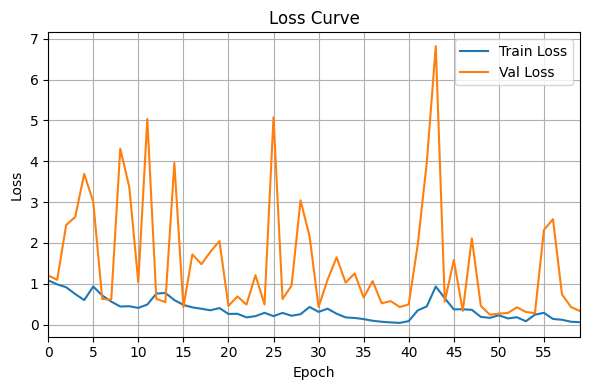

In [38]:
plot_loss(loss_path=GOOGLE_DRIVE_PATH + "/logs/rna_seq_cnn/loss_history_{0}.json".format(model_no), figsize=(6, 4))

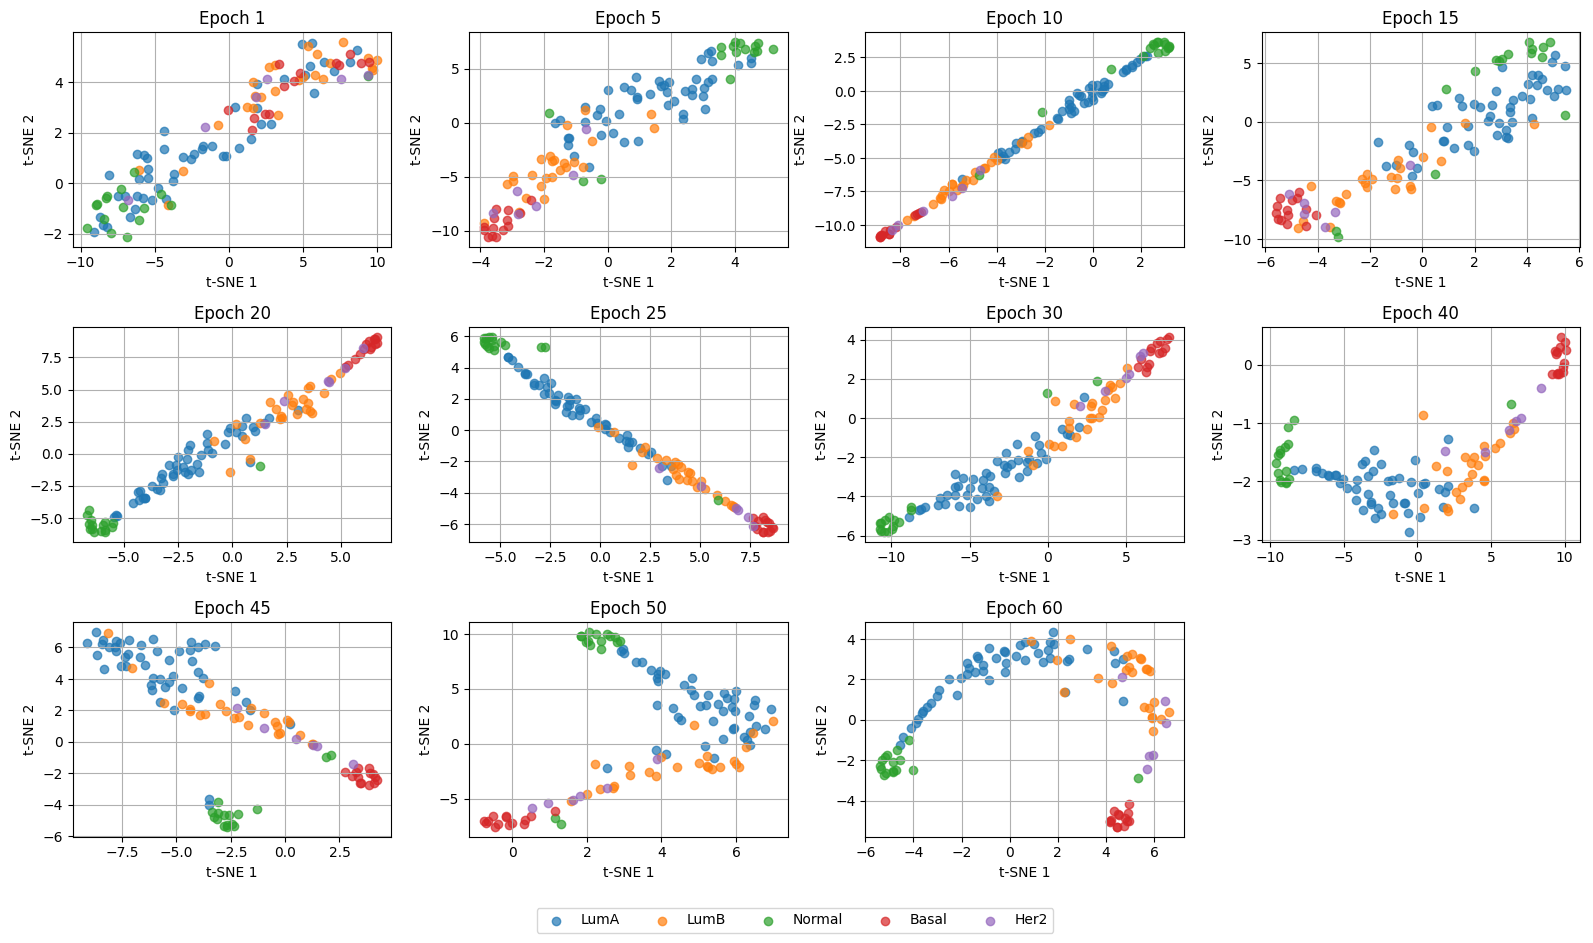

In [39]:
plot_tsne(tsne_path=GOOGLE_DRIVE_PATH + "/logs/rna_seq_cnn/tsne_results_{0}.pkl".format(model_no), epochs=[1, 5, 10, 15, 20, 25, 30, 40,45, 50, 60], cols=4, figsize=(4, 3))

In [40]:
#  Inspect file contents

file_npz = GOOGLE_DRIVE_PATH + "/data/clean_data/multimodal_data_features.npz"
with np.load(file_npz, allow_pickle=True) as data:
    print("Available keys:", list(data.keys()))
    print("RNA features shape:", data["rna_features"].shape)

Available keys: ['samples', 'mirna_features', 'rna_features', 'methylation_features', 'class_map', 'metadata']
RNA features shape: (13054,)


In [41]:
# Get gene names and class mapping

with np.load(file_npz, allow_pickle=True) as data:
    gene_names = data["rna_features"]
    class_map = data['class_map']

gene_names, class_map

(array(['?|10357', '?|10431', '?|155060', ..., 'ZZEF1|23140', 'ZZZ3|26009',
        'psiTPTE22|387590'], dtype=object),
 array({'LumA': 0, 'LumB': 1, 'Normal': 2, 'Basal': 3, 'Her2': 4},
       dtype=object))

In [42]:
class_map.item()

{'LumA': 0, 'LumB': 1, 'Normal': 2, 'Basal': 3, 'Her2': 4}

In [43]:
from utils.interpretability import compute_average_saliency_by_class, plot_saliency_radar
import pandas as pd
# 1. Your trained model and test dataloader

singleomics_model.eval()
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
singleomics_model.to(device)

# 2. Compute average saliency for RNA modality
saliency_by_class = compute_average_saliency_by_class(
    model=singleomics_model,
    dataloader=dataloaders['test'],
    modality_key='rna',           # or 'mirna', 'methyl'
    max_per_class=50,
    device=device
)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [44]:
id_to_type = {v:k for k, v in class_map.item().items()}
df_saliency_by_class = pd.DataFrame(saliency_by_class, index=gene_names).rename(columns=id_to_type)
df_saliency_by_class

,LumB,LumA,Basal,Normal,Her2
?|10357,0.002275,0.002267,0.002526,0.001079,0.002654
?|10431,0.002003,0.001840,0.008140,0.001602,0.002926
?|155060,0.002106,0.001258,0.005204,0.000670,0.005051
?|57714,0.003293,0.003095,0.002150,0.001358,0.004303
?|653553,0.002061,0.001531,0.014314,0.003520,0.004644
...,...,...,...,...,...
ZYG11B|79699,0.000721,0.000556,0.000517,0.000109,0.000899
ZYX|7791,0.000326,0.000286,0.000270,0.000072,0.000390
ZZEF1|23140,0.000090,0.000092,0.000109,0.000050,0.000264
ZZZ3|26009,0.000123,0.000053,0.000370,0.000040,0.000278


In [45]:
top5_by_class = {cls: df_saliency_by_class[cls].nlargest(5).index.tolist()
                 for cls in df_saliency_by_class.columns}

bottom5_by_class = {cls: df_saliency_by_class[cls].nsmallest(5).index.tolist()
                    for cls in df_saliency_by_class.columns}

In [46]:
top5_by_class

{'LumB': ['ACTG2|72',
  'NAA35|60560',
  'SHISA2|387914',
  'C21orf45|54069',
  'PYCR1|5831'],
 'LumA': ['ACTG2|72',
  'NAA35|60560',
  'FOXC1|2296',
  'TSPAN33|340348',
  'FOXL1|2300'],
 'Basal': ['ABHD12|26090',
  'GSTCD|79807',
  'TMSB15B|286527',
  'ACP5|54',
  'CCDC7|221016'],
 'Normal': ['TSPAN13|27075',
  'TCF4|6925',
  'DDX3X|1654',
  'SLC38A10|124565',
  'ADPGK|83440'],
 'Her2': ['C4orf32|132720',
  'ACTG2|72',
  'RPL27|6155',
  'SHISA2|387914',
  'RPL28|6158']}

In [47]:
# Extract top and bottom 5 genes per class
summary_table = []

for cls in df_saliency_by_class.columns:
    top_genes = df_saliency_by_class[cls].nlargest(5).index.tolist()
    bottom_genes = df_saliency_by_class[cls].nsmallest(5).index.tolist()

    top_genes = [g.split("|")[0] for g in top_genes]
    bottom_genes = [g.split("|")[0] for g in bottom_genes]

    summary_table.append({
        "Subtype": cls,
        "Top 5 Genes": ", ".join(top_genes),
        "Bottom 5 Genes": ", ".join(bottom_genes)
    })

df_summary = pd.DataFrame(summary_table)

In [48]:
df_summary

,Subtype,Top 5 Genes,Bottom 5 Genes
0,LumB,"ACTG2, NAA35, SHISA2, C21orf45, PYCR1","ZZEF1, ZZZ3, LOC653566, LOC650368, NUTF2"
1,LumA,"ACTG2, NAA35, FOXC1, TSPAN33, FOXL1","ZZZ3, ZZEF1, psiTPTE22, LOC647979, LOC653501"
2,Basal,"ABHD12, GSTCD, TMSB15B, ACP5, CCDC7","ZZEF1, psiTPTE22, ZYX, CLPB, ZNF85"
3,Normal,"TSPAN13, TCF4, DDX3X, SLC38A10, ADPGK","psiTPTE22, ZZZ3, LOC100130093, LOC646214, ZZEF1"
4,Her2,"C4orf32, ACTG2, RPL27, SHISA2, RPL28","C2CD2L, UBC, ZNF195, ZNF781, ZNF107"


In [49]:
# Apply styling with renamed headers

display_df = df_summary.rename(columns={
    "Top 5 Genes": "Most Contributing Genes",
    "Bottom 5 Genes": "Least Contributing Genes"
})

styled_table = (
    display_df.style
    .set_table_styles([
        # 1. Top border
        {"selector": "", "props": [("border-top", "2px solid black !important")]},
        # 2. Header bottom border
        {"selector": "thead th", "props": [("border-bottom", "1px solid black !important")]},
        # 3. Bottom border
        {"selector": "", "props": [("border-bottom", "2px solid black !important")]},
        # Cell formatting
        {"selector": "th, td", "props": [
            ("padding", "8px"),
            ("text-align", "left"),
            ("border", "none !important")
        ]}
    ])
    .hide(axis="index")
    .set_caption("Most and Least Contributory Genes for Breast Cancer Subtype Prediction")
    .set_properties(**{'border-collapse': 'collapse'})
    # Rename columns for display only
    .set_table_styles([
        {"selector": "th.col_heading.level0", "props": [("font-weight", "bold")]},
    ], overwrite=False)
)

# Rename headers in the display (without changing DataFrame)


# Display in Jupyter
display(styled_table)

Subtype,Most Contributing Genes,Least Contributing Genes
LumB,"ACTG2, NAA35, SHISA2, C21orf45, PYCR1","ZZEF1, ZZZ3, LOC653566, LOC650368, NUTF2"
LumA,"ACTG2, NAA35, FOXC1, TSPAN33, FOXL1","ZZZ3, ZZEF1, psiTPTE22, LOC647979, LOC653501"
Basal,"ABHD12, GSTCD, TMSB15B, ACP5, CCDC7","ZZEF1, psiTPTE22, ZYX, CLPB, ZNF85"
Normal,"TSPAN13, TCF4, DDX3X, SLC38A10, ADPGK","psiTPTE22, ZZZ3, LOC100130093, LOC646214, ZZEF1"
Her2,"C4orf32, ACTG2, RPL27, SHISA2, RPL28","C2CD2L, UBC, ZNF195, ZNF781, ZNF107"


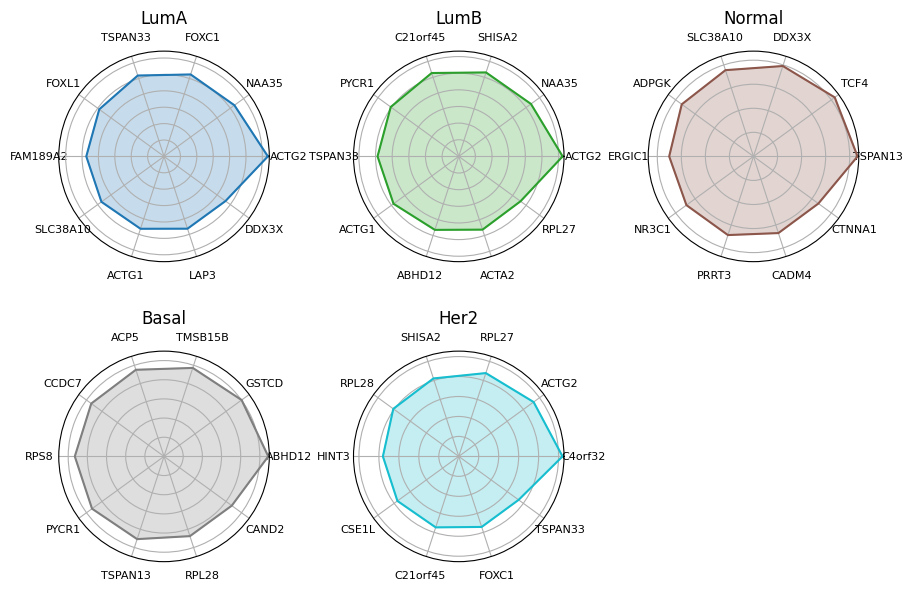

In [50]:
# Check the most

plot_saliency_radar(
    class_saliency=saliency_by_class,
    top_n=10,  # or 15
    gene_names=[gene.split("|")[0] for gene in gene_names],
    id_to_type={v:k for k, v in class_map.item().items()},
    ncol=3, figsize=(10, 10)
)